## Karar Destek Mekanizmaları

Veri setinden akademik personelin performansını ve başarılarını analiz ederek, çeşitli karar destek mekanizmaları oluşturmak.

In [1]:
# Gerekli kütüphanelerin yüklenmesi
%pip install pandas scikit-learn matplotlib seaborn
%pip install statsmodels
%pip install xgboost lightgbm
%pip install imbalanced-learn
%pip install scikit-optimize
%pip install tensorflow
%pip install setuptools
%pip install --upgrade setuptools
%pip install pmdarima
%pip install arch
%pip install pydlm
%pip install tbats




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
import warnings
from pmdarima import auto_arima
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy import stats
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from arch import arch_model
from pydlm import dlm, trend
from tbats import TBATS
print("Kurulumlar başarılı!")

Kurulumlar başarılı!


In [3]:
# Excel dosyasını okuma
file_name = 'expdata.xlsx'
# DataFrame'i daha şık görüntüleme
df = pd.read_excel(file_name, engine='openpyxl') 
# Tablo görüntüleme
df.head()  

c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Person ID,Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler,Yıl
0,124,Araştırma Görevlisi,Kadın,0,2,0,0,0,0,0,30.11.2018
1,124,Araştırma Görevlisi,Kadın,0,19,0,0,0,0,0,28.12.2023
2,124,Araştırma Görevlisi,Kadın,0,1,0,0,0,0,0,28.03.2022
3,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023
4,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023


In [4]:
# Veri setinin boyutlarını öğrenme
print(df.shape)

(29684, 11)


In [5]:
# Sütun adlarını ve veri tiplerini görüntüleme
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29684 entries, 0 to 29683
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               29684 non-null  int64 
 1   Akademik Personel Tipi  29684 non-null  object
 2   Cinsiyet Bilgisi        29684 non-null  object
 3   Ödüller                 29684 non-null  int64 
 4   Sunduğu bildiriler      29684 non-null  int64 
 5   Yayınlanmış makale      29684 non-null  int64 
 6   Aldığı atıflar          29684 non-null  int64 
 7   Kitap yazımı            29684 non-null  int64 
 8   Yaptığı editörlükler    29684 non-null  int64 
 9   Yönetilen tezler        29684 non-null  int64 
 10  Yıl                     29684 non-null  object
dtypes: int64(8), object(3)
memory usage: 2.5+ MB
None


In [6]:
# Eksik verileri kontrol etme
print(df.isnull().sum())

Person ID                 0
Akademik Personel Tipi    0
Cinsiyet Bilgisi          0
Ödüller                   0
Sunduğu bildiriler        0
Yayınlanmış makale        0
Aldığı atıflar            0
Kitap yazımı              0
Yaptığı editörlükler      0
Yönetilen tezler          0
Yıl                       0
dtype: int64


In [7]:
# Sütun adlarını görüntüleme
print("Orijinal Sütunlar:", df.columns)

Orijinal Sütunlar: Index(['Person ID', 'Akademik Personel Tipi', 'Cinsiyet Bilgisi', 'Ödüller',
       'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar',
       'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler', 'Yıl'],
      dtype='object')


In [8]:
# Veri setindeki kategorik ve sayısal değişkenleri ayırma
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

print(f"Kategorik Sütunlar: {categorical_cols}")
print(f"Sayısal Sütunlar: {numerical_cols}")

Kategorik Sütunlar: Index(['Akademik Personel Tipi', 'Cinsiyet Bilgisi', 'Yıl'], dtype='object')
Sayısal Sütunlar: Index(['Person ID', 'Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale',
       'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler',
       'Yönetilen tezler'],
      dtype='object')


In [9]:
# Hatalı sonuç alamamak adına 'Person ID' sütununu kategorik veriye çevirme ve görüntüleme
df['Person ID'] = df['Person ID'].astype('object')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29684 entries, 0 to 29683
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               29684 non-null  object
 1   Akademik Personel Tipi  29684 non-null  object
 2   Cinsiyet Bilgisi        29684 non-null  object
 3   Ödüller                 29684 non-null  int64 
 4   Sunduğu bildiriler      29684 non-null  int64 
 5   Yayınlanmış makale      29684 non-null  int64 
 6   Aldığı atıflar          29684 non-null  int64 
 7   Kitap yazımı            29684 non-null  int64 
 8   Yaptığı editörlükler    29684 non-null  int64 
 9   Yönetilen tezler        29684 non-null  int64 
 10  Yıl                     29684 non-null  object
dtypes: int64(7), object(4)
memory usage: 2.5+ MB
None


In [10]:
# Kontrol
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

print(f"Kategorik Sütunlar: {categorical_cols}")
print(f"Sayısal Sütunlar: {numerical_cols}")

Kategorik Sütunlar: Index(['Person ID', 'Akademik Personel Tipi', 'Cinsiyet Bilgisi', 'Yıl'], dtype='object')
Sayısal Sütunlar: Index(['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar',
       'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler'],
      dtype='object')


In [11]:
# Kategorik sütunlar ve benzersiz değerlerin sayısını hesaplama
unique_counts = {
    'Person ID': len(df['Person ID'].unique()),
    'Akademik Personel Tipi': len(df['Akademik Personel Tipi'].unique()),
    'Cinsiyet Bilgisi': len(df['Cinsiyet Bilgisi'].unique()),
    'Yıl': len(df['Yıl'].unique()),
}

# Sonuçları yazdırma
print("Kategorik Sütunların Benzersiz Değer Sayıları:")
for column, count in unique_counts.items():
    print(f"{column}: {count} benzersiz değer")

Kategorik Sütunların Benzersiz Değer Sayıları:
Person ID: 1078 benzersiz değer
Akademik Personel Tipi: 10 benzersiz değer
Cinsiyet Bilgisi: 2 benzersiz değer
Yıl: 3840 benzersiz değer


In [12]:
# Yıl kısmını yakından inceleme
unique_values_yil = df['Yıl'].unique()
print({textwrap.fill(', '.join(unique_values_yil))})

{'30.11.2018, 28.12.2023, 28.03.2022, 2023, 2022, 2021, 2020, 2019,\n2018, 2017, 2016, 18.11.2016, 16.04.2017, 12.09.2017, 11.10.2017,\n10.03.2018, 01.12.2018, 20.10.2019, 13.11.2018, 2012, 26.04.2015,\n25.06.2014, 2015, 2014, 2013, 2011, 2010, 2009, 2008, 2007, 2006,\n2005, 2004, 2003, 2001, 2000, 1998, 19.12.2020, 19.10.2018,\n15.09.2021, 14.05.2016, 12.05.2019, 30.09.2018, 30.07.2021,\n27.09.2017, 26.09.2018, 25.09.2017, 2002, 17.05.2018, 13.05.2018,\n12.05.2018, 09.09.2018, 08.12.2019, 06.09.2018, 30.12.2018,\n30.10.2017, 30.09.2017, 30.04.2017, 29.10.2018, 27.09.2018,\n26.04.2017, 23.12.2018, 22.09.2019, 20.12.2018, 19.09.2019,\n14.09.2017, 14.09.2016, 13.12.2018, 01.12.2017, 01.09.2019,\n01.06.2017, 17.11.2019, 02.11.2010, 28.05.2008, 26.08.2007,\n25.09.2002, 25.06.2003, 24.10.2018, 24.05.2006, 23.04.2009, 2024,\n20.04.2007, 17.09.2014, 17.05.2007, 15.10.2023, 15.06.2007,\n12.04.2007, 09.10.2017, 05.09.2007, 04.09.2007, 02.11.2007,\n01.07.2007, 23.04.2016, 31.08.2019, 28.10.2015,

In [13]:
# Yıl sütunundan gün-ay-yıl ve sadece yıl ayırma işlemi
def extract_year(date_str):
    try:
        # Tarih değerini ayırma
        date_parts = date_str.split('.')
        if len(date_parts) == 3:
            # Gün-ay-yıl formatında, sadece yılı alma
            return date_parts[-1]
        elif len(date_parts) == 1:
            # Yalnızca yıl formatında
            return date_str
        else:
            # Geçersiz format
            return np.nan
    except Exception as e:
        print(f"Error processing {date_str}: {e}")
        return np.nan

# Yeni yıl sütunu oluşturma
df['Yıl(Güncellenmiş)'] = df['Yıl'].apply(extract_year)

df.head()

,Person ID,Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler,Yıl,Yıl(Güncellenmiş)
0,124,Araştırma Görevlisi,Kadın,0,2,0,0,0,0,0,30.11.2018,2018
1,124,Araştırma Görevlisi,Kadın,0,19,0,0,0,0,0,28.12.2023,2023
2,124,Araştırma Görevlisi,Kadın,0,1,0,0,0,0,0,28.03.2022,2022
3,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023,2023
4,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023,2023


In [14]:
# Eski Yıl sütunun atma
df = df.drop(columns=['Yıl'])

# Güncellenmiş veri setinin kaydedilmesi ve görüntülenmesi
df.to_csv('cleaned_data_year.csv', index=False)
df.head()

,Person ID,Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler,Yıl(Güncellenmiş)
0,124,Araştırma Görevlisi,Kadın,0,2,0,0,0,0,0,2018
1,124,Araştırma Görevlisi,Kadın,0,19,0,0,0,0,0,2023
2,124,Araştırma Görevlisi,Kadın,0,1,0,0,0,0,0,2022
3,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023
4,124,Araştırma Görevlisi,Kadın,0,0,0,24,6,0,0,2023


In [15]:
# Kategorik sütunlar ve benzersiz değerlerin sayısını yeniden hesaplama
unique_counts = {
    'Person ID': len(df['Person ID'].unique()),
    'Akademik Personel Tipi': len(df['Akademik Personel Tipi'].unique()),
    'Cinsiyet Bilgisi': len(df['Cinsiyet Bilgisi'].unique()),
    'Yıl': len(df['Yıl(Güncellenmiş)'].unique()),
}

# Sonuçları yazdırma
print("Kategorik Sütunların Benzersiz Değer Sayıları:")
for column, count in unique_counts.items():
    print(f"{column}: {count} benzersiz değer")

Kategorik Sütunların Benzersiz Değer Sayıları:
Person ID: 1078 benzersiz değer
Akademik Personel Tipi: 10 benzersiz değer
Cinsiyet Bilgisi: 2 benzersiz değer
Yıl: 64 benzersiz değer


In [16]:
# Hata kontrolü için kategorik veri içeren sütunların benzersiz değerlerinin görüntülenmesi
# Benzersiz değerlerin listesi

unique_values_person = map(str,df['Person ID'].unique())
unique_values_personel = df['Akademik Personel Tipi'].unique()
unique_values_cinsiyet = df['Cinsiyet Bilgisi'].unique()
unique_values_yil = df['Yıl(Güncellenmiş)'].unique()

# Tabloyu oluşturma
output = f"""
Benzersiz Değerler Tablosu:

Person ID:
{textwrap.fill(', '.join(unique_values_person), width=800)}

Akademik Personel Tipi:
{', '.join(unique_values_personel)}

Cinsiyet:
{', '.join(unique_values_cinsiyet)}

Yıl:
{textwrap.fill(', '.join(unique_values_yil), width=180)}

"""

print(output)


Benzersiz Değerler Tablosu:

Person ID:
124, 276, 285, 294, 295, 296, 301, 302, 304, 308, 311, 312, 313, 316, 317, 341, 345, 347, 371, 375, 384, 396, 399, 400, 401, 406, 417, 418, 420, 439, 443, 444, 445, 447, 449, 452, 453, 454, 455, 457, 458, 459, 460, 461, 462, 465, 466, 468, 469, 478, 484, 488, 493, 496, 497, 499, 500, 506, 507, 508, 509, 510, 511, 513, 533, 535, 537, 538, 539, 540, 541, 542, 546, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 566, 567, 568, 569, 572, 573, 576, 581, 585, 589, 593, 596, 597, 602, 603, 605, 606, 614, 618, 619, 621, 638, 639, 642, 643, 706, 718, 1084, 1102, 1103, 1106, 1107, 1110, 1111, 1112, 1113, 1115, 1116, 1118, 1119, 1123, 1124, 1125, 1130, 1160, 1189, 1198, 1200, 1202, 1211, 1219, 1221, 1309, 1310, 1311, 1314, 1315, 1316, 1322, 1323, 1324, 1325, 1331, 1344,
1362, 1382, 1384, 1390, 1404, 1407, 1413, 1417, 1445, 1473, 1480, 1497, 1500, 1503, 1526, 1530, 1534, 1536, 1540, 1543, 1548, 1550, 1552, 1558, 1560, 1562, 1564, 

In [17]:
# Yıl sütununda geçerli değerleri filtreleme
def is_valid_year(year_str):
    try:
        year = int(year_str)
        # Yılın dört basamaktan oluştuğundan ve makul bir aralıkta olduğundan emin olma
        return 1900 <= year <= 2100
    except ValueError:
        return False

# Geçerli yıl değerlerini içeren yeni DataFrame oluşturma
df = df[df['Yıl(Güncellenmiş)'].apply(is_valid_year)]

In [18]:
# Yeniden benzeriz değer görüntüleme

unique_values_person = map(str,df['Person ID'].unique())
unique_values_personel = df['Akademik Personel Tipi'].unique()
unique_values_cinsiyet = df['Cinsiyet Bilgisi'].unique()
unique_values_yil = df['Yıl(Güncellenmiş)'].unique()

# Tabloyu oluşturma
output = f"""
Benzersiz Değerler Tablosu:

Person ID:
{textwrap.fill(', '.join(unique_values_person), width=800)}

Akademik Personel Tipi:
{', '.join(unique_values_personel)}

Cinsiyet:
{', '.join(unique_values_cinsiyet)}

Yıl:
{textwrap.fill(', '.join(unique_values_yil), width=180)}

"""

print(output)


Benzersiz Değerler Tablosu:

Person ID:
124, 276, 285, 294, 295, 296, 301, 302, 304, 308, 311, 312, 313, 316, 317, 341, 345, 347, 371, 375, 384, 396, 399, 400, 401, 406, 417, 418, 420, 439, 443, 444, 445, 447, 449, 452, 453, 454, 455, 457, 458, 459, 460, 461, 462, 465, 466, 468, 469, 478, 484, 488, 493, 496, 497, 499, 500, 506, 507, 508, 509, 510, 511, 513, 533, 535, 537, 538, 539, 540, 541, 542, 546, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 566, 567, 568, 569, 572, 573, 576, 581, 585, 589, 593, 596, 597, 602, 603, 605, 606, 614, 618, 619, 621, 638, 639, 642, 643, 706, 718, 1084, 1102, 1103, 1106, 1107, 1110, 1111, 1112, 1113, 1115, 1116, 1118, 1119, 1123, 1124, 1125, 1130, 1160, 1189, 1198, 1200, 1202, 1211, 1219, 1221, 1309, 1310, 1311, 1314, 1315, 1316, 1322, 1323, 1324, 1325, 1331, 1344,
1362, 1382, 1384, 1390, 1404, 1407, 1413, 1417, 1445, 1473, 1480, 1497, 1500, 1503, 1526, 1530, 1534, 1536, 1540, 1543, 1548, 1550, 1552, 1558, 1560, 1562, 1564, 

In [19]:
# Satır tekrarı kontrolü 
# Tekrar eden satırları belirleme
duplicates = df[df.duplicated()]
print(duplicates)

      Person ID Akademik Personel Tipi Cinsiyet Bilgisi  Ödüller  \
4           124    Araştırma Görevlisi            Kadın        0   
6           124    Araştırma Görevlisi            Kadın        0   
7           124    Araştırma Görevlisi            Kadın        0   
9           124    Araştırma Görevlisi            Kadın        0   
10          124    Araştırma Görevlisi            Kadın        0   
...         ...                    ...              ...      ...   
29668   1181872   Doktor Öğretim Üyesi            Erkek        0   
29669   1181872   Doktor Öğretim Üyesi            Erkek        0   
29670   1181872   Doktor Öğretim Üyesi            Erkek        0   
29671   1181872   Doktor Öğretim Üyesi            Erkek        0   
29683   1182250   Doktor Öğretim Üyesi            Kadın        0   

       Sunduğu bildiriler  Yayınlanmış makale  Aldığı atıflar  Kitap yazımı  \
4                       0                   0              24             6   
6                       0

In [20]:
# Tekrar eden satırları kaldırma
df = df.drop_duplicates()
print(df)

      Person ID Akademik Personel Tipi Cinsiyet Bilgisi  Ödüller  \
0           124    Araştırma Görevlisi            Kadın        0   
1           124    Araştırma Görevlisi            Kadın        0   
2           124    Araştırma Görevlisi            Kadın        0   
3           124    Araştırma Görevlisi            Kadın        0   
5           124    Araştırma Görevlisi            Kadın        0   
...         ...                    ...              ...      ...   
29678   1182250   Doktor Öğretim Üyesi            Kadın        0   
29679   1182250   Doktor Öğretim Üyesi            Kadın        0   
29680   1182250   Doktor Öğretim Üyesi            Kadın        0   
29681   1182250   Doktor Öğretim Üyesi            Kadın        0   
29682   1182250   Doktor Öğretim Üyesi            Kadın        0   

       Sunduğu bildiriler  Yayınlanmış makale  Aldığı atıflar  Kitap yazımı  \
0                       2                   0               0             0   
1                      19

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18178 entries, 0 to 29682
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               18178 non-null  object
 1   Akademik Personel Tipi  18178 non-null  object
 2   Cinsiyet Bilgisi        18178 non-null  object
 3   Ödüller                 18178 non-null  int64 
 4   Sunduğu bildiriler      18178 non-null  int64 
 5   Yayınlanmış makale      18178 non-null  int64 
 6   Aldığı atıflar          18178 non-null  int64 
 7   Kitap yazımı            18178 non-null  int64 
 8   Yaptığı editörlükler    18178 non-null  int64 
 9   Yönetilen tezler        18178 non-null  int64 
 10  Yıl(Güncellenmiş)       18178 non-null  object
dtypes: int64(7), object(4)
memory usage: 1.7+ MB


In [22]:
# Aynı Person ID ve Yıl içeren satırları grupla ve toplama işlemi yap
df = df.groupby(['Person ID', 'Yıl(Güncellenmiş)'], as_index=False).agg({
    'Akademik Personel Tipi': 'first',  # İlk değeri al
    'Cinsiyet Bilgisi': 'first',         # İlk değeri al 
    'Ödüller': 'sum',
    'Sunduğu bildiriler': 'sum',
    'Yayınlanmış makale': 'sum',
    'Aldığı atıflar': 'sum',
    'Kitap yazımı': 'sum',
    'Yaptığı editörlükler': 'sum',
    'Yönetilen tezler': 'sum'
})

# Sonuçları kontrol et
df.head()

,Person ID,Yıl(Güncellenmiş),Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
0,124,2016,Araştırma Görevlisi,Kadın,0,2,1,0,0,0,0
1,124,2017,Araştırma Görevlisi,Kadın,0,3,8,0,2,0,0
2,124,2018,Araştırma Görevlisi,Kadın,0,3,1,0,0,0,0
3,124,2019,Araştırma Görevlisi,Kadın,0,0,5,0,0,0,0
4,124,2020,Araştırma Görevlisi,Kadın,0,0,3,6,8,0,0


In [23]:
# Güncellenmiş veri setinin kaydedilmesi ve görüntülenmesi
df.to_csv('cleaned_data_year.csv', index=False)
df.head()

,Person ID,Yıl(Güncellenmiş),Akademik Personel Tipi,Cinsiyet Bilgisi,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
0,124,2016,Araştırma Görevlisi,Kadın,0,2,1,0,0,0,0
1,124,2017,Araştırma Görevlisi,Kadın,0,3,8,0,2,0,0
2,124,2018,Araştırma Görevlisi,Kadın,0,3,1,0,0,0,0
3,124,2019,Araştırma Görevlisi,Kadın,0,0,5,0,0,0,0
4,124,2020,Araştırma Görevlisi,Kadın,0,0,3,6,8,0,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11691 entries, 0 to 11690
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               11691 non-null  object
 1   Yıl(Güncellenmiş)       11691 non-null  object
 2   Akademik Personel Tipi  11691 non-null  object
 3   Cinsiyet Bilgisi        11691 non-null  object
 4   Ödüller                 11691 non-null  int64 
 5   Sunduğu bildiriler      11691 non-null  int64 
 6   Yayınlanmış makale      11691 non-null  int64 
 7   Aldığı atıflar          11691 non-null  int64 
 8   Kitap yazımı            11691 non-null  int64 
 9   Yaptığı editörlükler    11691 non-null  int64 
 10  Yönetilen tezler        11691 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1004.8+ KB


In [25]:
# Veri setinin istatistiksel özetini alma
print(df.describe())

            Ödüller  Sunduğu bildiriler  Yayınlanmış makale  Aldığı atıflar  \
count  11691.000000        11691.000000        11691.000000    11691.000000   
mean       0.565478            2.616286            4.173723        2.733641   
std        4.071964            9.786640           11.603472       12.009536   
min        0.000000            0.000000            0.000000        0.000000   
25%        0.000000            0.000000            0.000000        0.000000   
50%        0.000000            0.000000            2.000000        0.000000   
75%        0.000000            1.000000            4.000000        0.000000   
max      202.000000          313.000000          320.000000      546.000000   

       Kitap yazımı  Yaptığı editörlükler  Yönetilen tezler  
count  11691.000000          11691.000000      11691.000000  
mean       1.657087              0.663844          1.184586  
std        8.673393              5.516775          6.541711  
min        0.000000              0.00000

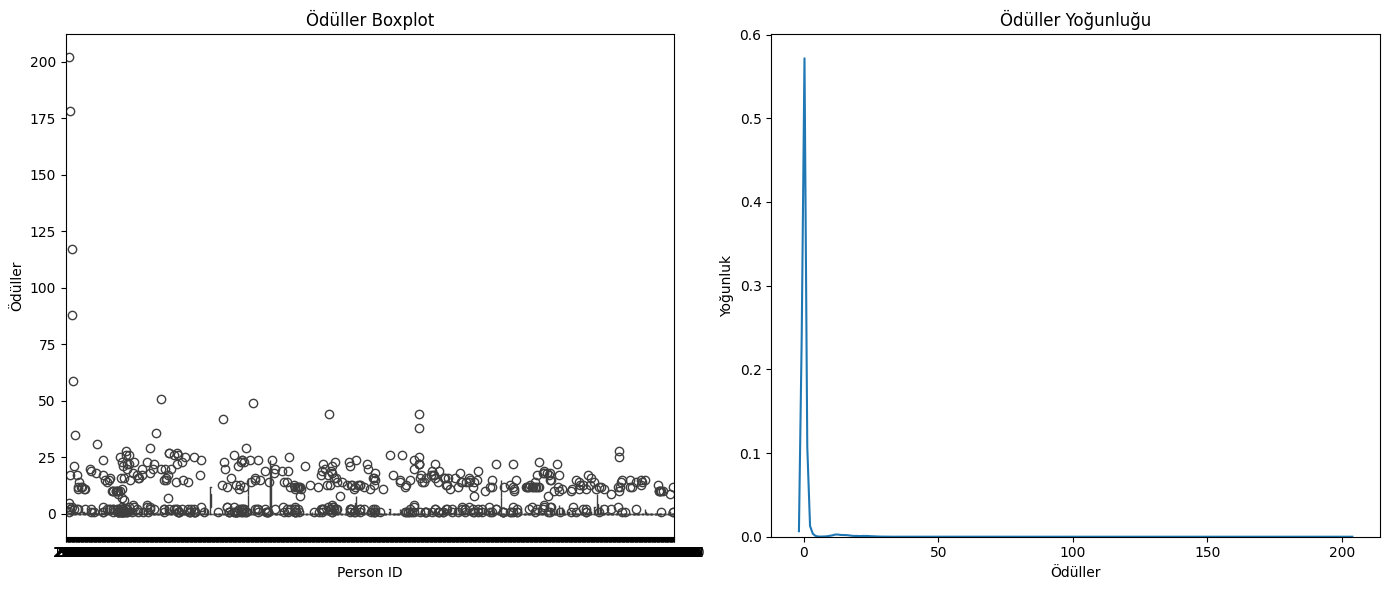

In [26]:
# Temizlenmiş veri ile boxplot ve KDE grafiği oluşturma
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Örnek: Ödüller
# Boxplot
sns.boxplot(x='Person ID', y='Ödüller', data=df, ax=axes[0])
axes[0].set_title('Ödüller Boxplot')
axes[0].set_xlabel('Person ID')
axes[0].set_ylabel('Ödüller')

# KDE grafiği
sns.kdeplot(df['Ödüller'], ax=axes[1])
axes[1].set_xlabel('Ödüller')
axes[1].set_ylabel('Yoğunluk')
axes[1].set_title('Ödüller Yoğunluğu')

plt.tight_layout()
plt.show()



In [27]:
# Sayısal verilerin kontrolünde yanlış veya hatalı girilmiş olabilecek değerler keşfedildi (Çok sayıda outlier).
# Konu ile ilgili araştırma yapıldıktan sonra sınırlar belirlendi ve veri sınırlara göre yeniden düzenlendi.

In [28]:
# İlk veri setinden temizlenmiş veri oluşturma
df_cleaned = df.copy()

# Ödüller için özel sınırlar
valid_awards = (df_cleaned['Ödüller'] >= 0) & (df_cleaned['Ödüller'] <= 5)
df_cleaned = df_cleaned[valid_awards]

# Bildiri Sunma için sınır
valid_presentations = (df_cleaned['Sunduğu bildiriler'] >= 0) & (df_cleaned['Sunduğu bildiriler'] <= 20)
df_cleaned = df_cleaned[valid_presentations]

# Makale Yayınlama için sınır
valid_publications = (df_cleaned['Yayınlanmış makale'] >= 0) & (df_cleaned['Yayınlanmış makale'] <= 20)
df_cleaned = df_cleaned[valid_publications]

# Atıf için sınır
valid_citations = (df_cleaned['Aldığı atıflar'] >= 0) & (df_cleaned['Aldığı atıflar'] <= 100)
df_cleaned = df_cleaned[valid_citations]

# Kitap Yazma için sınır
valid_books = df_cleaned['Kitap yazımı'] < 5
df_cleaned = df_cleaned[valid_books]

# Editörlük için sınır
valid_editorship = (df_cleaned['Yaptığı editörlükler'] >= 0) & (df_cleaned['Yaptığı editörlükler'] <= 5)
df_cleaned = df_cleaned[valid_editorship]

# Tez Yönetimi için sınır
valid_thesis_supervision = (df_cleaned['Yönetilen tezler'] >= 0) & (df_cleaned['Yönetilen tezler'] <= 10)
df_cleaned = df_cleaned[valid_thesis_supervision]

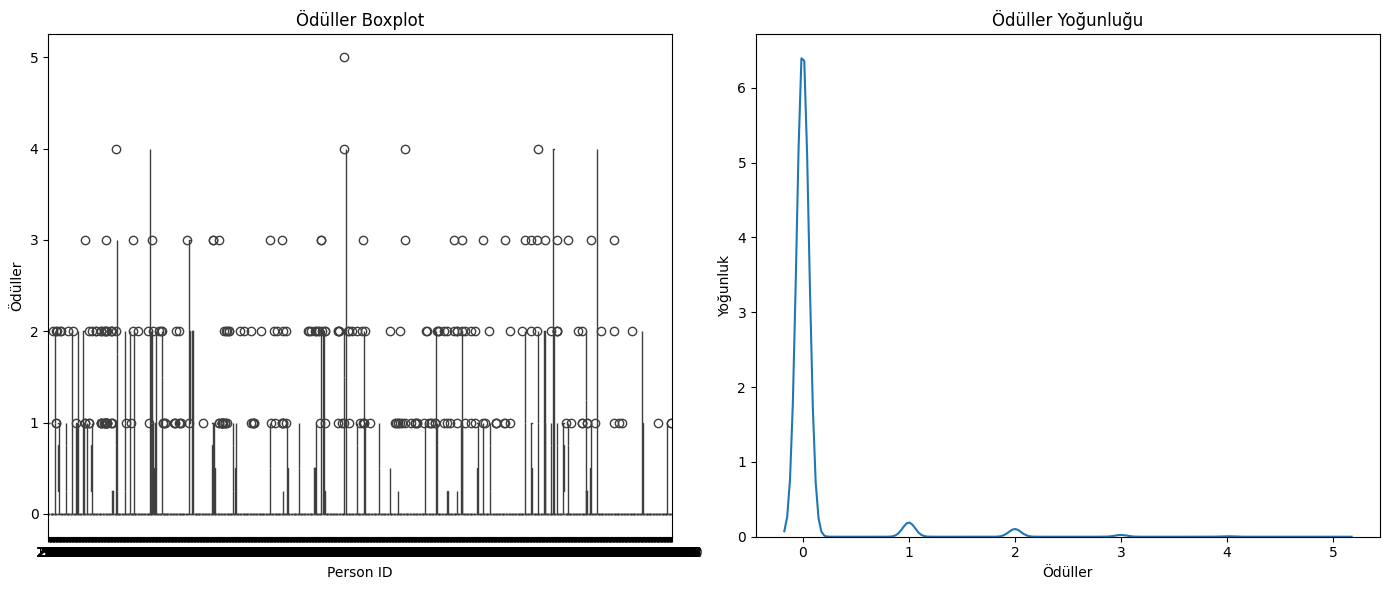

In [29]:
# Temizlenmiş veri ile boxplot ve KDE grafiği oluşturma
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
sns.boxplot(x='Person ID', y='Ödüller', data=df_cleaned, ax=axes[0])
axes[0].set_title('Ödüller Boxplot')
axes[0].set_xlabel('Person ID')
axes[0].set_ylabel('Ödüller')

# KDE grafiği
sns.kdeplot(df_cleaned['Ödüller'], ax=axes[1])
axes[1].set_xlabel('Ödüller')
axes[1].set_ylabel('Yoğunluk')
axes[1].set_title('Ödüller Yoğunluğu')

plt.tight_layout()
plt.show()


In [30]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9448 entries, 0 to 11689
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               9448 non-null   object
 1   Yıl(Güncellenmiş)       9448 non-null   object
 2   Akademik Personel Tipi  9448 non-null   object
 3   Cinsiyet Bilgisi        9448 non-null   object
 4   Ödüller                 9448 non-null   int64 
 5   Sunduğu bildiriler      9448 non-null   int64 
 6   Yayınlanmış makale      9448 non-null   int64 
 7   Aldığı atıflar          9448 non-null   int64 
 8   Kitap yazımı            9448 non-null   int64 
 9   Yaptığı editörlükler    9448 non-null   int64 
 10  Yönetilen tezler        9448 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 885.8+ KB


Cinsiyet Bilgisi üzerine çalışma

In [31]:
# Cinsiyet ve diğer değişkenlerle ilgili alt veri seti oluşturma
variables_of_interest = ['Cinsiyet Bilgisi', 'Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']
df_subset = df_cleaned[variables_of_interest]

In [32]:
# Cinsiyete göre özet istatistikleri hesaplama
summary_stats = df_subset.groupby('Cinsiyet Bilgisi').describe()

# Her bir parametreyi alt alta yazdırmak için döngü
for gender, stats in summary_stats.groupby(level=0):
    print(f"\n{gender} İçin Özeti:")
    for column in stats.columns.levels[0]:
        print(f"\n{column}:")
        print(stats[column])



Erkek İçin Özeti:

Ödüller:
                   count      mean       std  min  25%  50%  75%  max
Cinsiyet Bilgisi                                                     
Erkek             5501.0  0.061807  0.331659  0.0  0.0  0.0  0.0  4.0

Sunduğu bildiriler:
                   count      mean       std  min  25%  50%  75%   max
Cinsiyet Bilgisi                                                      
Erkek             5501.0  1.510453  3.375221  0.0  0.0  0.0  1.0  20.0

Yayınlanmış makale:
                   count      mean       std  min  25%  50%  75%   max
Cinsiyet Bilgisi                                                      
Erkek             5501.0  2.792583  3.888312  0.0  0.0  1.0  3.0  20.0

Aldığı atıflar:
                   count      mean       std  min  25%  50%  75%   max
Cinsiyet Bilgisi                                                      
Erkek             5501.0  1.900745  5.348063  0.0  0.0  0.0  0.0  48.0

Kitap yazımı:
                   count      mean       std  mi

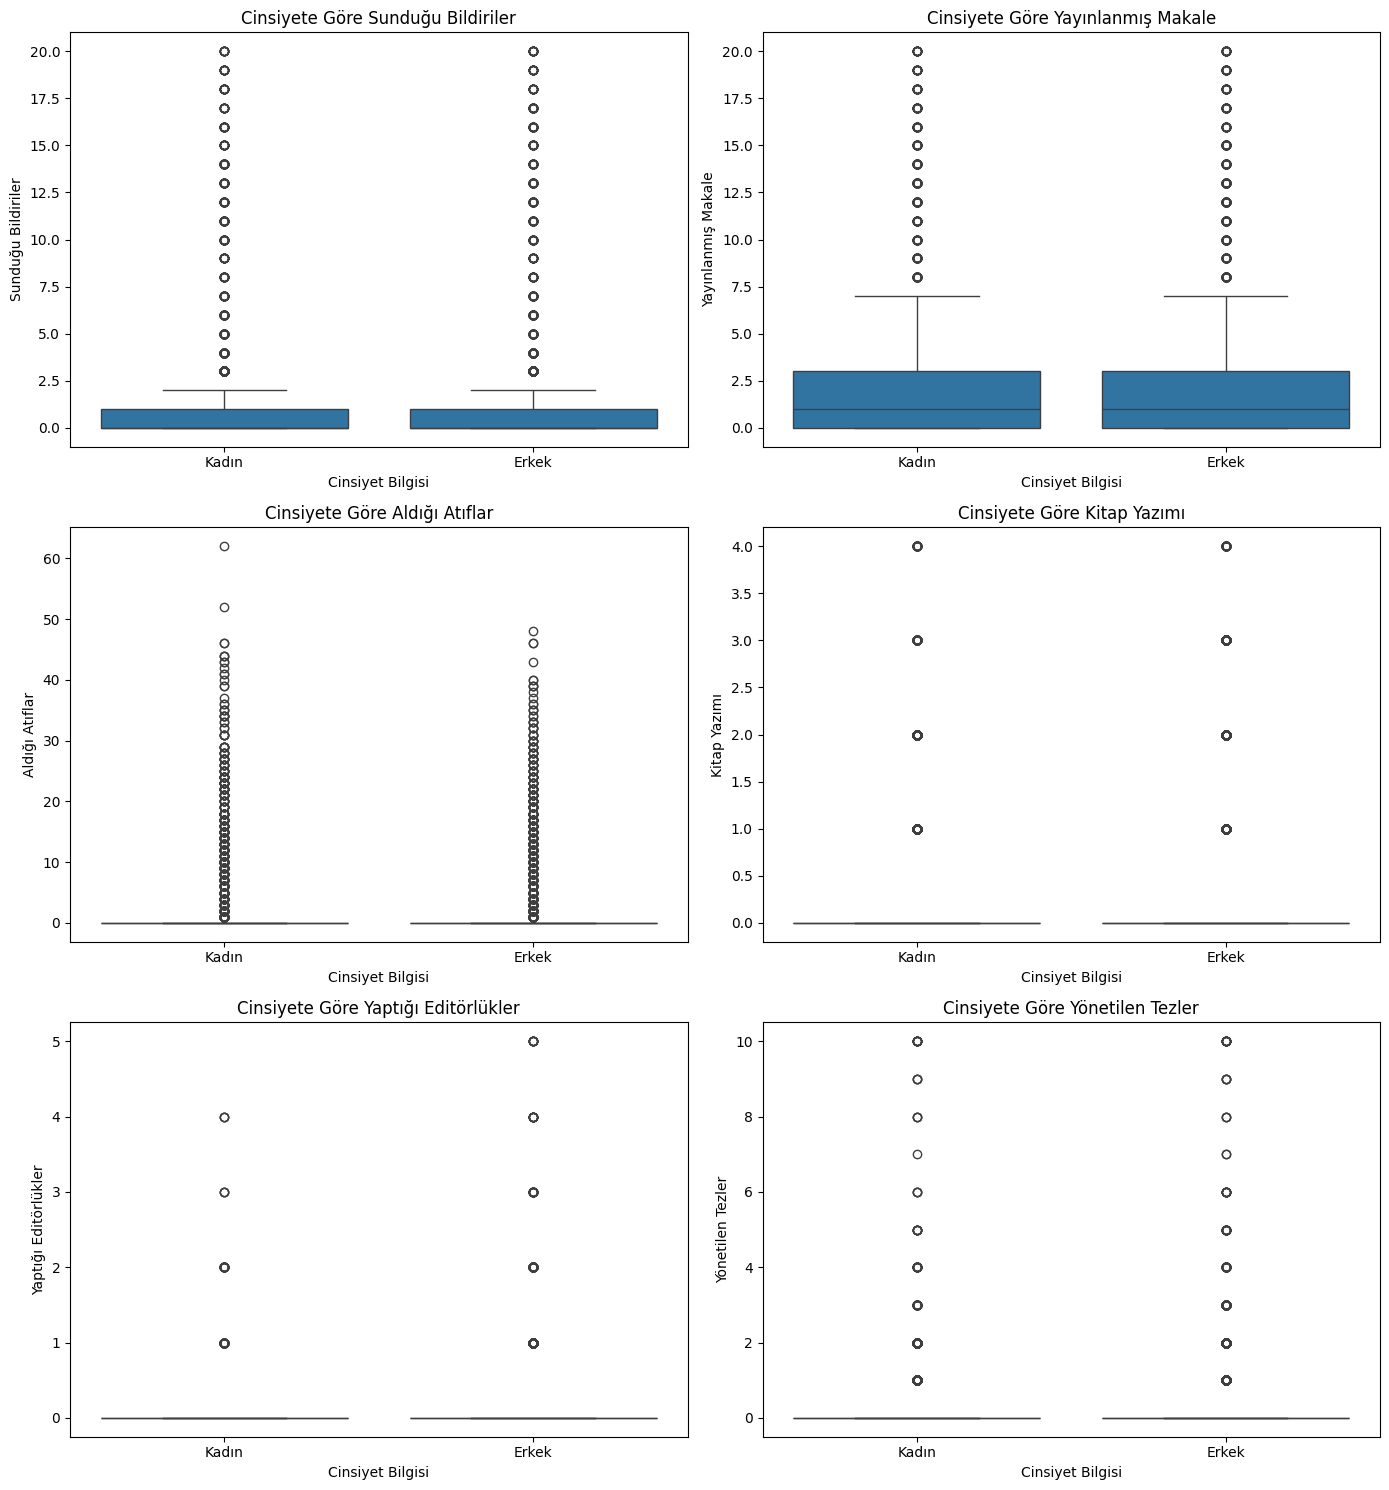

In [33]:
# Temizlenmiş veri ile görselleştirme
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Sunduğu Bildiriler
sns.boxplot(x='Cinsiyet Bilgisi', y='Sunduğu bildiriler', data=df_subset, ax=axes[0, 0])
axes[0, 0].set_title('Cinsiyete Göre Sunduğu Bildiriler')
axes[0, 0].set_xlabel('Cinsiyet Bilgisi')
axes[0, 0].set_ylabel('Sunduğu Bildiriler')

# Yayınlanmış Makale
sns.boxplot(x='Cinsiyet Bilgisi', y='Yayınlanmış makale', data=df_subset, ax=axes[0, 1])
axes[0, 1].set_title('Cinsiyete Göre Yayınlanmış Makale')
axes[0, 1].set_xlabel('Cinsiyet Bilgisi')
axes[0, 1].set_ylabel('Yayınlanmış Makale')

# Aldığı Atıflar
sns.boxplot(x='Cinsiyet Bilgisi', y='Aldığı atıflar', data=df_subset, ax=axes[1, 0])
axes[1, 0].set_title('Cinsiyete Göre Aldığı Atıflar')
axes[1, 0].set_xlabel('Cinsiyet Bilgisi')
axes[1, 0].set_ylabel('Aldığı Atıflar')

# Kitap Yazımı
sns.boxplot(x='Cinsiyet Bilgisi', y='Kitap yazımı', data=df_subset, ax=axes[1, 1])
axes[1, 1].set_title('Cinsiyete Göre Kitap Yazımı')
axes[1, 1].set_xlabel('Cinsiyet Bilgisi')
axes[1, 1].set_ylabel('Kitap Yazımı')

# Editörlük
sns.boxplot(x='Cinsiyet Bilgisi', y='Yaptığı editörlükler', data=df_subset, ax=axes[2, 0])
axes[2, 0].set_title('Cinsiyete Göre Yaptığı Editörlükler')
axes[2, 0].set_xlabel('Cinsiyet Bilgisi')
axes[2, 0].set_ylabel('Yaptığı Editörlükler')

# Tez Yönetimi
sns.boxplot(x='Cinsiyet Bilgisi', y='Yönetilen tezler', data=df_subset, ax=axes[2, 1])
axes[2, 1].set_title('Cinsiyete Göre Yönetilen Tezler')
axes[2, 1].set_xlabel('Cinsiyet Bilgisi')
axes[2, 1].set_ylabel('Yönetilen Tezler')

plt.tight_layout()
plt.show()


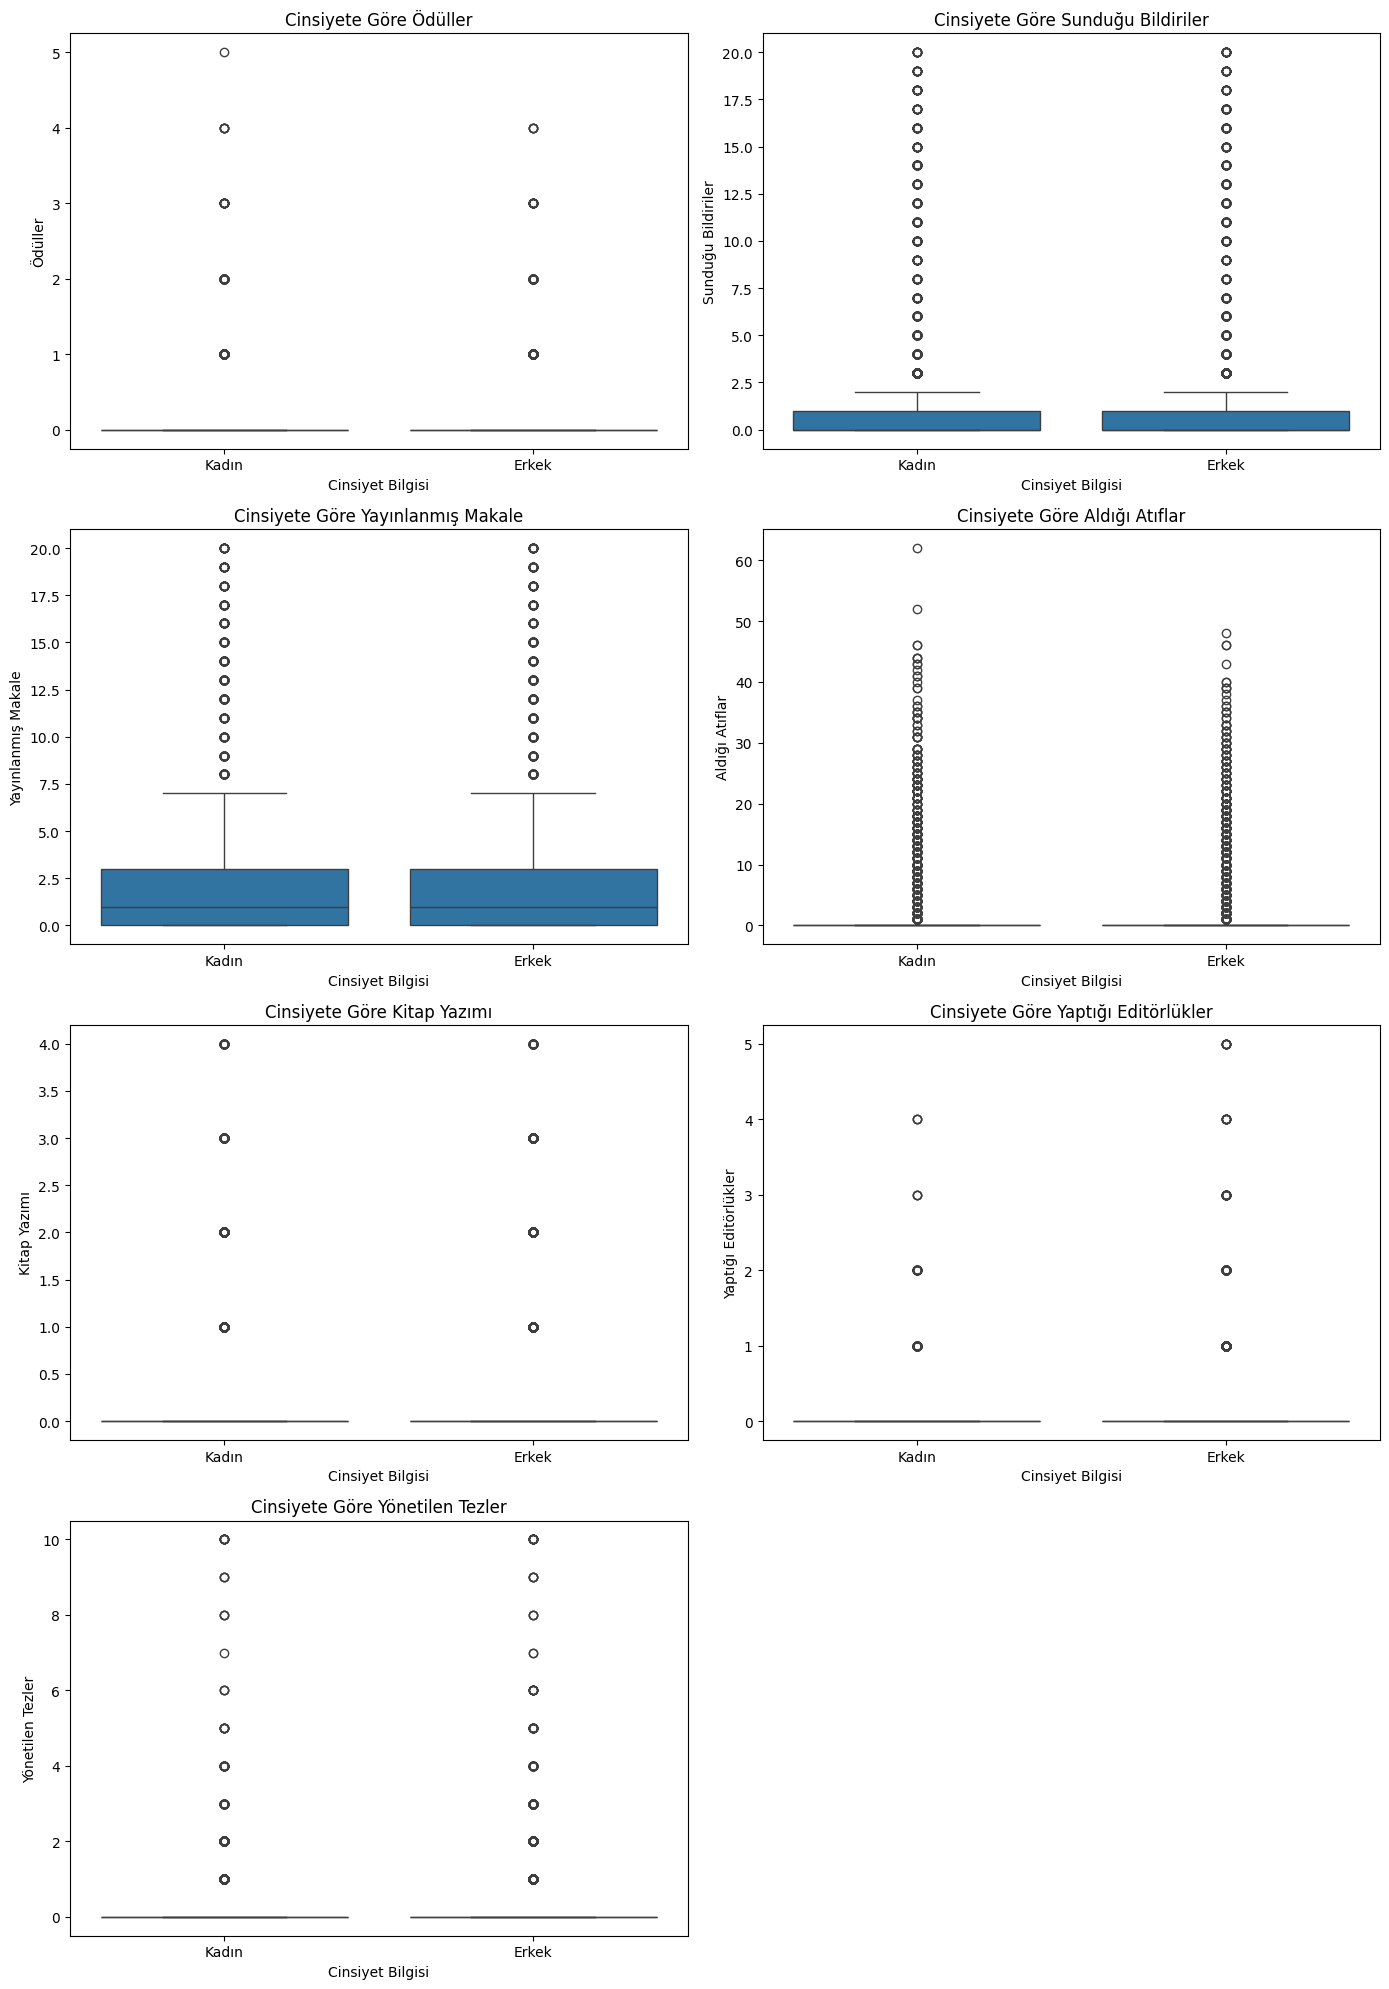

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Temizlenmiş veri ile görselleştirme
fig, axes = plt.subplots(4, 2, figsize=(14, 20))

# Ödüller
sns.boxplot(x='Cinsiyet Bilgisi', y='Ödüller', data=df_subset, ax=axes[0, 0])
axes[0, 0].set_title('Cinsiyete Göre Ödüller')
axes[0, 0].set_xlabel('Cinsiyet Bilgisi')
axes[0, 0].set_ylabel('Ödüller')

# Sunduğu Bildiriler
sns.boxplot(x='Cinsiyet Bilgisi', y='Sunduğu bildiriler', data=df_subset, ax=axes[0, 1])
axes[0, 1].set_title('Cinsiyete Göre Sunduğu Bildiriler')
axes[0, 1].set_xlabel('Cinsiyet Bilgisi')
axes[0, 1].set_ylabel('Sunduğu Bildiriler')

# Yayınlanmış Makale
sns.boxplot(x='Cinsiyet Bilgisi', y='Yayınlanmış makale', data=df_subset, ax=axes[1, 0])
axes[1, 0].set_title('Cinsiyete Göre Yayınlanmış Makale')
axes[1, 0].set_xlabel('Cinsiyet Bilgisi')
axes[1, 0].set_ylabel('Yayınlanmış Makale')

# Aldığı Atıflar
sns.boxplot(x='Cinsiyet Bilgisi', y='Aldığı atıflar', data=df_subset, ax=axes[1, 1])
axes[1, 1].set_title('Cinsiyete Göre Aldığı Atıflar')
axes[1, 1].set_xlabel('Cinsiyet Bilgisi')
axes[1, 1].set_ylabel('Aldığı Atıflar')

# Kitap Yazımı
sns.boxplot(x='Cinsiyet Bilgisi', y='Kitap yazımı', data=df_subset, ax=axes[2, 0])
axes[2, 0].set_title('Cinsiyete Göre Kitap Yazımı')
axes[2, 0].set_xlabel('Cinsiyet Bilgisi')
axes[2, 0].set_ylabel('Kitap Yazımı')

# Editörlük
sns.boxplot(x='Cinsiyet Bilgisi', y='Yaptığı editörlükler', data=df_subset, ax=axes[2, 1])
axes[2, 1].set_title('Cinsiyete Göre Yaptığı Editörlükler')
axes[2, 1].set_xlabel('Cinsiyet Bilgisi')
axes[2, 1].set_ylabel('Yaptığı Editörlükler')

# Tez Yönetimi
sns.boxplot(x='Cinsiyet Bilgisi', y='Yönetilen tezler', data=df_subset, ax=axes[3, 0])
axes[3, 0].set_title('Cinsiyete Göre Yönetilen Tezler')
axes[3, 0].set_xlabel('Cinsiyet Bilgisi')
axes[3, 0].set_ylabel('Yönetilen Tezler')

# Boş olan subplotu kaldırmak için
fig.delaxes(axes[3, 1])

# Düzenlemeyi gösterme
plt.tight_layout()
plt.show()


In [37]:
# 'Ödüller' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
male_awards = df_subset[df_subset['Cinsiyet Bilgisi'] == 'Erkek']['Ödüller']
female_awards = df_subset[df_subset['Cinsiyet Bilgisi'] == 'Kadın']['Ödüller']

t_stat, p_val = stats.ttest_ind(male_awards, female_awards, nan_policy='omit')
print(f"Ödüller için T-Testi: : t-stat =  {t_stat:.3f}, p-Değeri: {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(male_awards, female_awards, alternative='two-sided')
print(f"Ödüller için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Ödüller için T-Testi: : t-stat =  -3.325, p-Değeri: 0.001
Ödüller için Mann-Whitney U Testi: U-stat = 10696219.500, p-değeri = 0.001


In [38]:
# 'Sunduğu bildiriler' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Sunduğu bildiriler']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Sunduğu bildiriler']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Sunduğu bildiriler için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Sunduğu bildiriler için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Sunduğu bildiriler için T-Testi: t-stat = -2.722, p-değeri = 0.006
Sunduğu bildiriler için Mann-Whitney U Testi: U-stat = 10263202.000, p-değeri = 0.000


In [39]:
# 'Yayınlanmış makale' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Yayınlanmış makale']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Yayınlanmış makale']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Yayınlanmış makale için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Yayınlanmış makale için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Yayınlanmış makale için T-Testi: t-stat = -1.235, p-değeri = 0.217
Yayınlanmış makale için Mann-Whitney U Testi: U-stat = 10775089.500, p-değeri = 0.527


In [40]:
# 'Aldığı atıflar' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Aldığı atıflar']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Aldığı atıflar']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Aldığı atıflar için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Aldığı atıflar için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Aldığı atıflar için T-Testi: t-stat = -2.779, p-değeri = 0.005
Aldığı atıflar için Mann-Whitney U Testi: U-stat = 10593761.500, p-değeri = 0.004


In [41]:
# 'Kitap yazımı' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Kitap yazımı']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Kitap yazımı']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Kitap yazımı için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Kitap yazımı için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Kitap yazımı için T-Testi: t-stat = -0.273, p-değeri = 0.785
Kitap yazımı için Mann-Whitney U Testi: U-stat = 10844701.500, p-değeri = 0.896


In [42]:
# 'Yaptığı editörlükler' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Yaptığı editörlükler']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Yaptığı editörlükler']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Yaptığı editörlükler için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Yaptığı editörlükler için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Yaptığı editörlükler için T-Testi: t-stat = 6.172, p-değeri = 0.000
Yaptığı editörlükler için Mann-Whitney U Testi: U-stat = 11130553.500, p-değeri = 0.000


In [43]:
# 'Yönetilen tezler' değişkeni için Cinsiyet Bilgisi'ne göre iki bağımsız örneklem t-testi
group1 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']['Yönetilen tezler']
group2 = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']['Yönetilen tezler']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
print(f"Yönetilen tezler için T-Testi: t-stat = {t_stat:.3f}, p-değeri = {p_val:.3f}")

# Mann-Whitney U Testi
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Yönetilen tezler için Mann-Whitney U Testi: U-stat = {u_stat:.3f}, p-değeri = {p_val:.3f}")


Yönetilen tezler için T-Testi: t-stat = 5.644, p-değeri = 0.000
Yönetilen tezler için Mann-Whitney U Testi: U-stat = 11510290.000, p-değeri = 0.000


In [44]:
# Cinsiyet Bilgisi gruplarını ayırma
group_male = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Erkek']
group_female = df_cleaned[df_cleaned['Cinsiyet Bilgisi'] == 'Kadın']

# Ödüller için ANOVA
f_stat_awards, p_val_awards = stats.f_oneway(group_male['Ödüller'], group_female['Ödüller'])

# Sunduğu Bildiriler için ANOVA
f_stat_presentations, p_val_presentations = stats.f_oneway(group_male['Sunduğu bildiriler'], group_female['Sunduğu bildiriler'])

# Yayınlanmış Makale için ANOVA
f_stat_publications, p_val_publications = stats.f_oneway(group_male['Yayınlanmış makale'], group_female['Yayınlanmış makale'])

# Aldığı Atıflar için ANOVA
f_stat_citations, p_val_citations = stats.f_oneway(group_male['Aldığı atıflar'], group_female['Aldığı atıflar'])

# Kitap Yazımı için ANOVA
f_stat_books, p_val_books = stats.f_oneway(group_male['Kitap yazımı'], group_female['Kitap yazımı'])

# Yaptığı Editörlükler için ANOVA
f_stat_editorship, p_val_editorship = stats.f_oneway(group_male['Yaptığı editörlükler'], group_female['Yaptığı editörlükler'])

# Yönetilen Tezler için ANOVA
f_stat_thesis, p_val_thesis = stats.f_oneway(group_male['Yönetilen tezler'], group_female['Yönetilen tezler'])

# Sonuçları yazdırma
print("Ödüller için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_awards}, p-değeri: {p_val_awards}")

print("\nSunduğu Bildiriler için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_presentations}, p-değeri: {p_val_presentations}")

print("\nYayınlanmış Makale için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_publications}, p-değeri: {p_val_publications}")

print("\nAldığı Atıflar için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_citations}, p-değeri: {p_val_citations}")

print("\nKitap Yazımı için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_books}, p-değeri: {p_val_books}")

print("\nYaptığı Editörlükler için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_editorship}, p-değeri: {p_val_editorship}")

print("\nYönetilen Tezler için ANOVA Sonuçları:")
print(f"F-istatistiği: {f_stat_thesis}, p-değeri: {p_val_thesis}")


Ödüller için ANOVA Sonuçları:
F-istatistiği: 11.05841167986571, p-değeri: 0.0008862222517466347

Sunduğu Bildiriler için ANOVA Sonuçları:
F-istatistiği: 7.411686660314133, p-değeri: 0.006492045608911619

Yayınlanmış Makale için ANOVA Sonuçları:
F-istatistiği: 1.5241091989107651, p-değeri: 0.21702941650672433

Aldığı Atıflar için ANOVA Sonuçları:
F-istatistiği: 7.724469295134737, p-değeri: 0.00545850572441757

Kitap Yazımı için ANOVA Sonuçları:
F-istatistiği: 0.07458389146023112, p-değeri: 0.7847819208824991

Yaptığı Editörlükler için ANOVA Sonuçları:
F-istatistiği: 38.090954046091454, p-değeri: 7.029832654037801e-10

Yönetilen Tezler için ANOVA Sonuçları:
F-istatistiği: 31.85369359205101, p-değeri: 1.7103155796417138e-08


### Genel Yorum
### Anlamlı Farklar: Ödüller, sunduğu bildiriler, aldığı atıflar, editörlükler ve yönetilen tezler açısından cinsiyetler arasında anlamlı farklar bulunuyor. (p-değeri < 0.05)
### Anlamlı Olmayan Farklar: Kitap yazımı ve yayınlanmış makaleler açısından anlamlı bir fark bulunmuyor.

Anlamlı farklar içeren 'Ödüller', 'Sunduğu Bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler' ve 'Yönetilen tezler' üzerine çalışma

C:\Users\elift\AppData\Local\Temp\ipykernel_11692\2162693330.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Erkek'][column], ax=ax, label='Erkek', shade=True)
C:\Users\elift\AppData\Local\Temp\ipykernel_11692\2162693330.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Kadın'][column], ax=ax, label='Kadın', shade=True)
C:\Users\elift\AppData\Local\Temp\ipykernel_11692\2162693330.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Erkek'][column], ax=ax, label='Erkek', shade=True)
C:\Users\elift\AppData\Local\Temp\

C:\Users\elift\AppData\Local\Temp\ipykernel_11692\2162693330.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Erkek'][column], ax=ax, label='Erkek', shade=True)
C:\Users\elift\AppData\Local\Temp\ipykernel_11692\2162693330.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Kadın'][column], ax=ax, label='Kadın', shade=True)


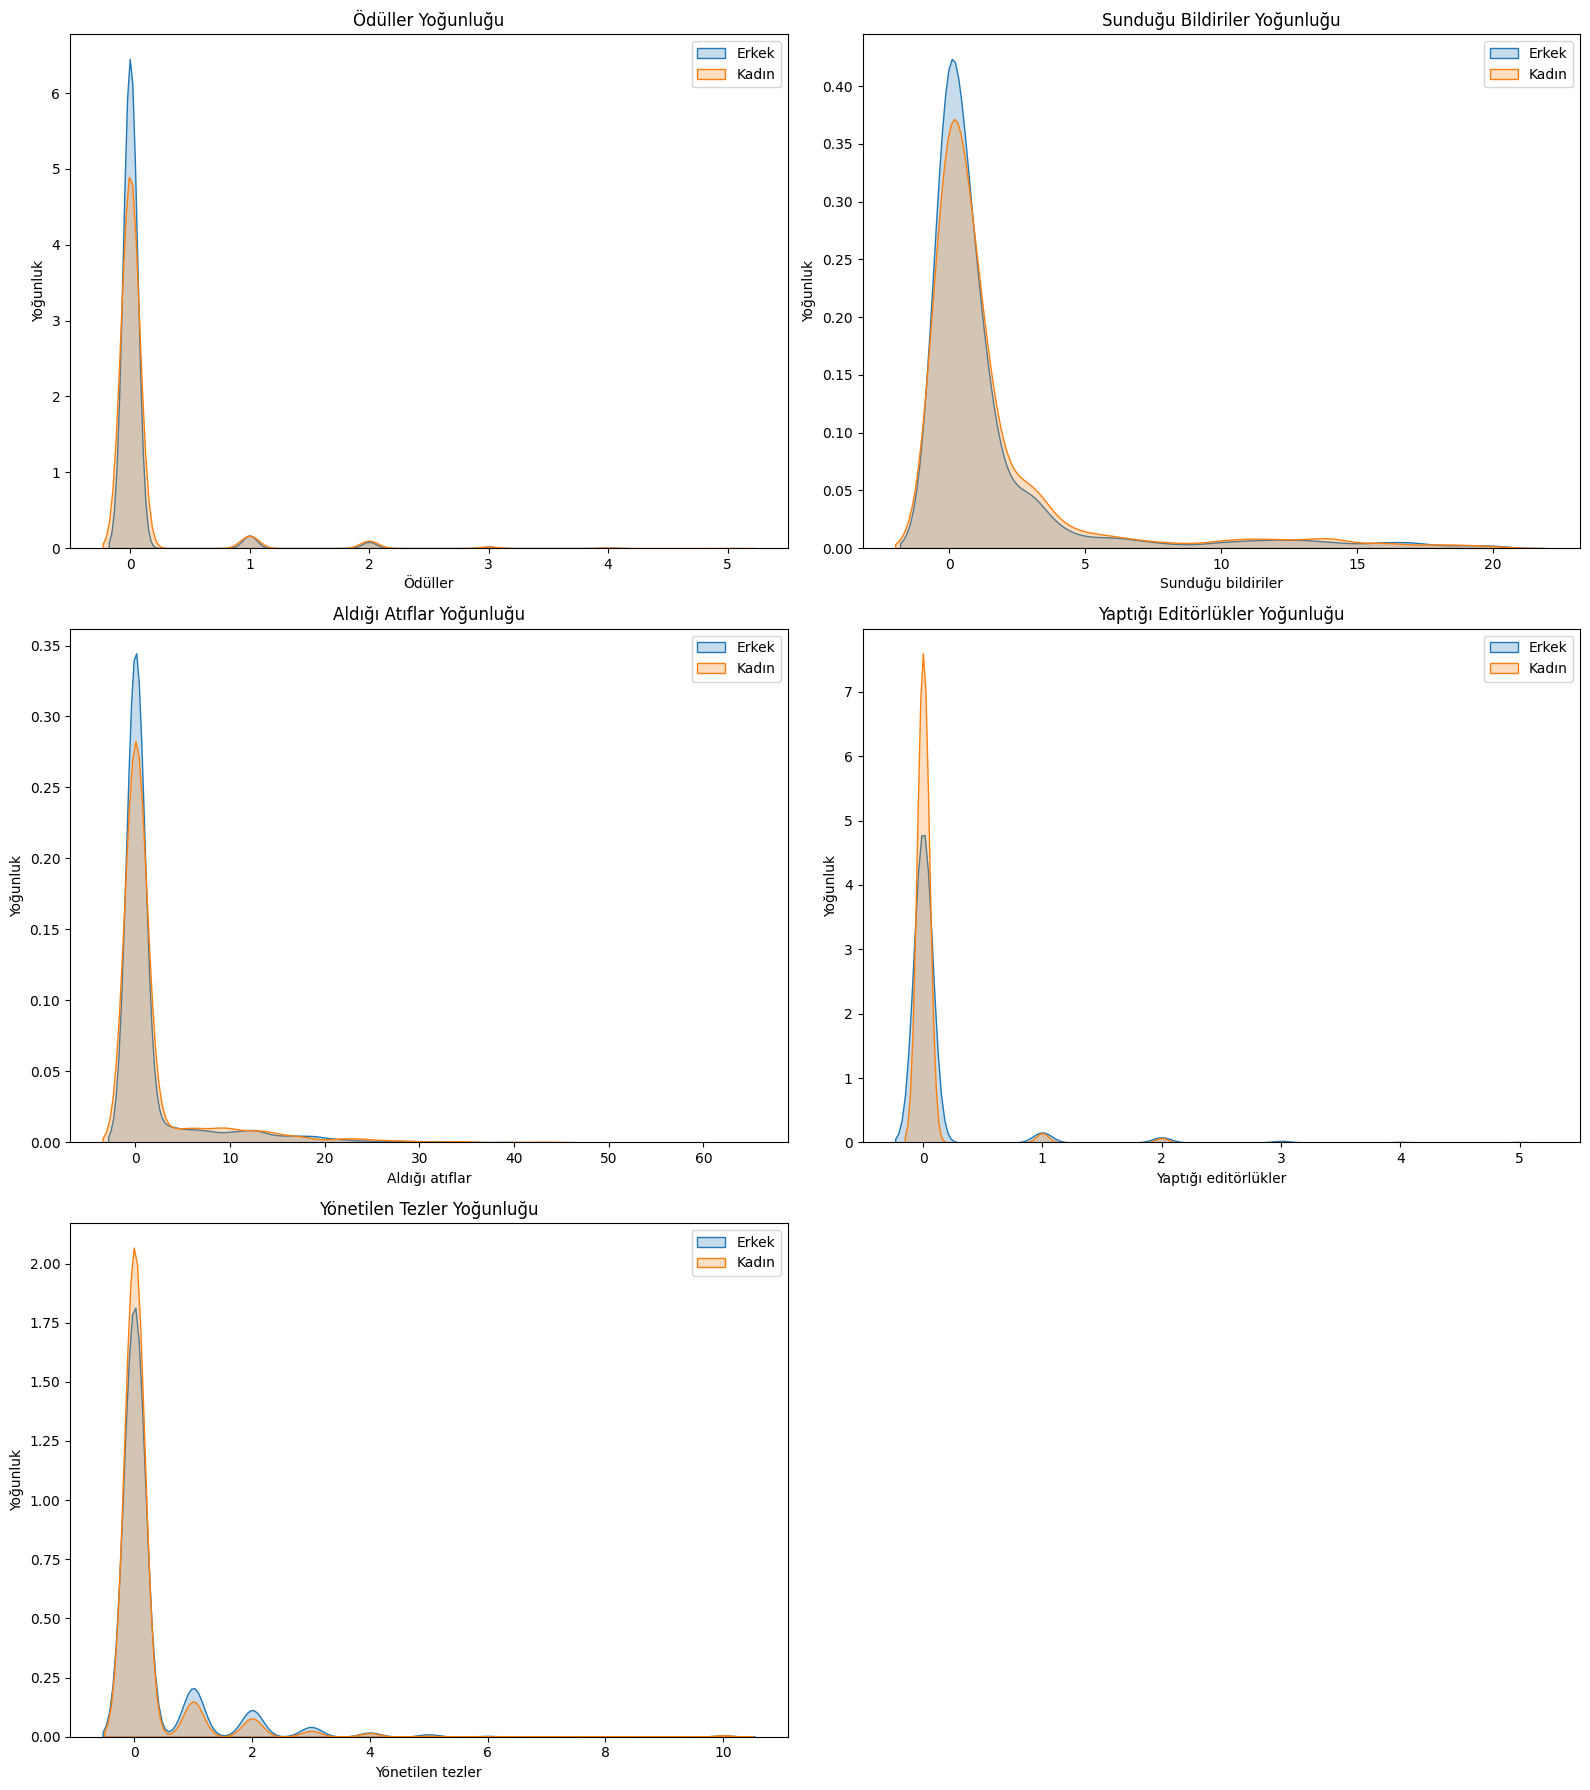

In [45]:
# KDE grafiği için görselleştirme fonksiyonu
def plot_kde(data, column, ax, title):
    sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Erkek'][column], ax=ax, label='Erkek', shade=True)
    sns.kdeplot(data[data['Cinsiyet Bilgisi'] == 'Kadın'][column], ax=ax, label='Kadın', shade=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Yoğunluk')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Ödüller KDE Grafiği
plot_kde(df_cleaned, 'Ödüller', axes[0, 0], 'Ödüller Yoğunluğu')

# Sunduğu Bildiriler KDE Grafiği
plot_kde(df_cleaned, 'Sunduğu bildiriler', axes[0, 1], 'Sunduğu Bildiriler Yoğunluğu')

# Aldığı Atıflar KDE Grafiği
plot_kde(df_cleaned, 'Aldığı atıflar', axes[1, 0], 'Aldığı Atıflar Yoğunluğu')

# Yaptığı Editörlükler KDE Grafiği
plot_kde(df_cleaned, 'Yaptığı editörlükler', axes[1, 1], 'Yaptığı Editörlükler Yoğunluğu')

# Yönetilen Tezler KDE Grafiği
plot_kde(df_cleaned, 'Yönetilen tezler', axes[2, 0], 'Yönetilen Tezler Yoğunluğu')

# Boş kalan grafiği kaldır
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


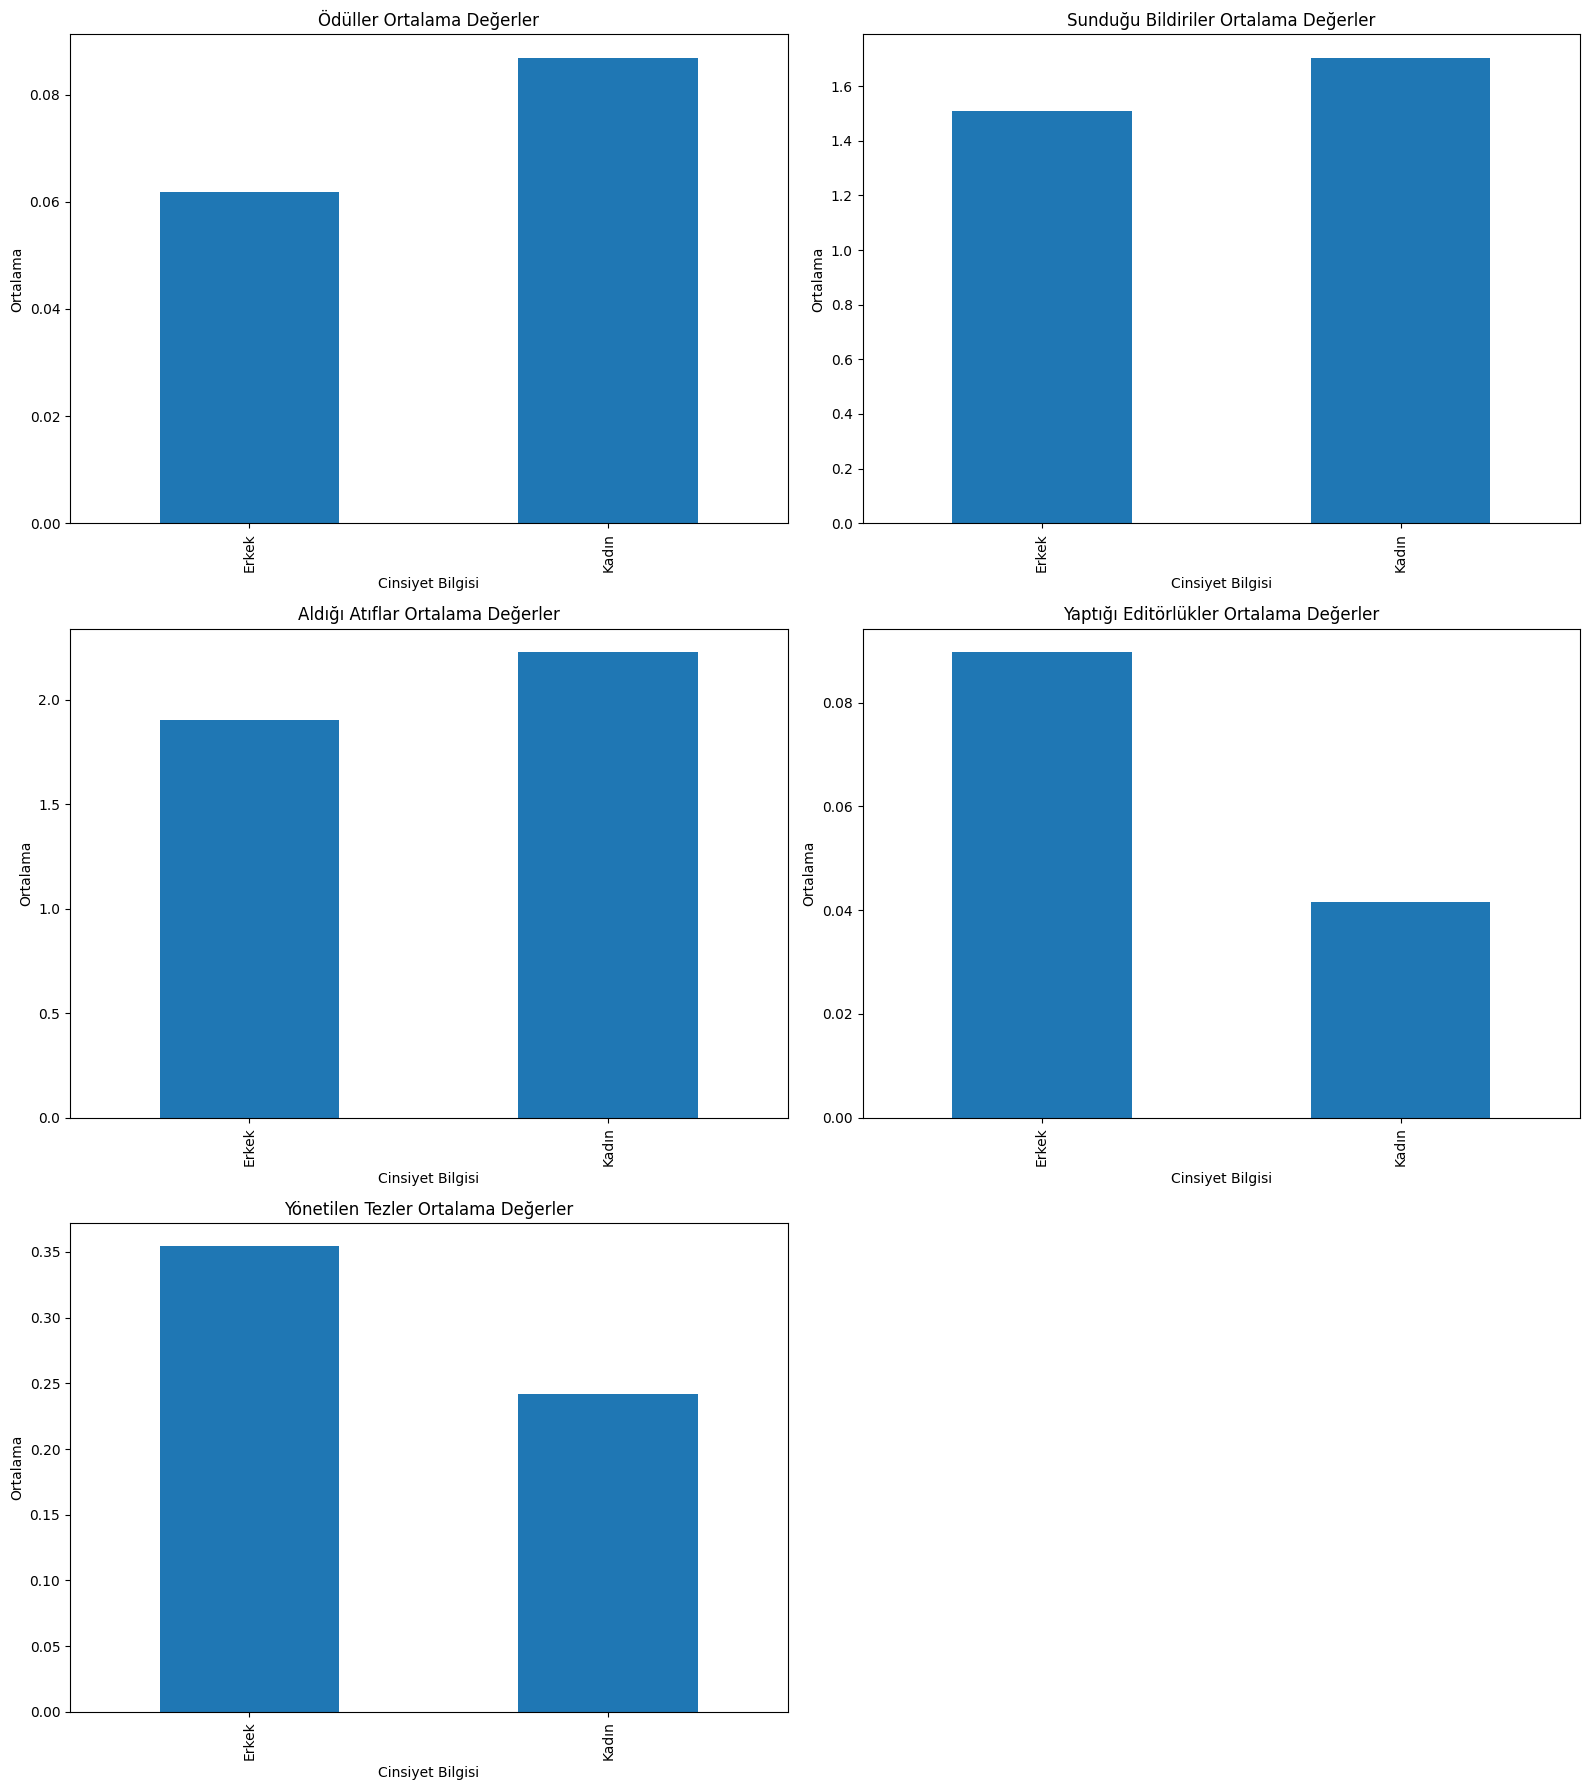

In [46]:
# Ortalama değerler için bar grafik fonksiyonu
def plot_bar(data, column, ax, title):
    means = data.groupby('Cinsiyet Bilgisi')[column].mean()
    means.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cinsiyet Bilgisi')
    ax.set_ylabel('Ortalama')

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Ödüller Bar Grafiği
plot_bar(df_cleaned, 'Ödüller', axes[0, 0], 'Ödüller Ortalama Değerler')

# Sunduğu Bildiriler Bar Grafiği
plot_bar(df_cleaned, 'Sunduğu bildiriler', axes[0, 1], 'Sunduğu Bildiriler Ortalama Değerler')

# Aldığı Atıflar Bar Grafiği
plot_bar(df_cleaned, 'Aldığı atıflar', axes[1, 0], 'Aldığı Atıflar Ortalama Değerler')

# Yaptığı Editörlükler Bar Grafiği
plot_bar(df_cleaned, 'Yaptığı editörlükler', axes[1, 1], 'Yaptığı Editörlükler Ortalama Değerler')

# Yönetilen Tezler Bar Grafiği
plot_bar(df_cleaned, 'Yönetilen tezler', axes[2, 0], 'Yönetilen Tezler Ortalama Değerler')

# Boş kalan grafiği kaldır
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


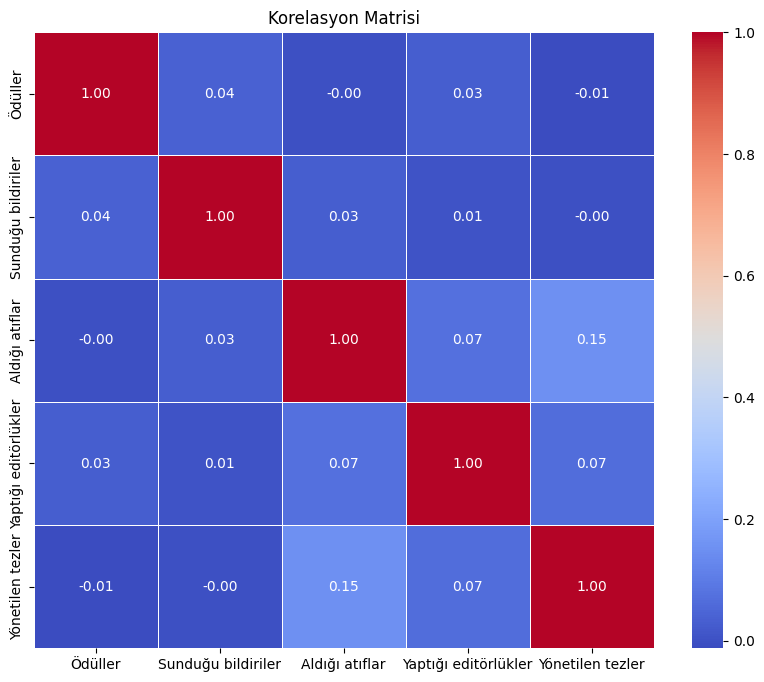

In [47]:
# Korelasyon matrisini hesaplama
correlation_matrix = df_cleaned[['Ödüller', 'Sunduğu bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler', 'Yönetilen tezler']].corr()

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korelasyon Matrisi')
plt.show()


Regresyon ve Sınıflandırma Analizleri

In [48]:
# Cinsiyet Bilgisi sütununu sayısal verilere dönüştürme
df_cleaned['Cinsiyet Bilgisi'] = df_cleaned['Cinsiyet Bilgisi'].map({'Kadın': 0, 'Erkek': 1})

In [49]:
# Regresyon Modelleri
# Özellikler ve hedef değişkenlerin belirlenmesi
features = ['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']
X = df_cleaned[features]
y = df_cleaned['Cinsiyet Bilgisi']  # Hedef değişken 'Cinsiyet Bilgisi'

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model listesini oluşturma
models1 = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'LogisticRegression': LogisticRegression(),
    'Lasso Regression': Lasso(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

# Modelleri eğitme ve değerlendirme

for name, model in models1.items():
    # Modeli eğitme
    model.fit(X_train, y_train)
    
    # Tahmin yapma
    y_pred = model.predict(X_test)
    
    # MSE ve R2 hesaplama
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Modeli:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R2: {r2:.4f}")
    print()

Linear Regression Modeli:
  MSE: 0.2409
  R2: 0.0091

Ridge Regression Modeli:
  MSE: 0.2409
  R2: 0.0091

LogisticRegression Modeli:
  MSE: 0.4176
  R2: -0.7180

Lasso Regression Modeli:
  MSE: 0.2431
  R2: -0.0000

Random Forest Regressor Modeli:
  MSE: 0.2568
  R2: -0.0562

Gradient Boosting Regressor Modeli:
  MSE: 0.2396
  R2: 0.0143

SVR Modeli:
  MSE: 0.3285
  R2: -0.3515



In [50]:
# Sınıflandırma Modelleri
# Uyarıları bastırma
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Özellikler ve hedef değişken
X = df_cleaned[['Ödüller', 'Sunduğu bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler', 'Yönetilen tezler']]
y = df_cleaned['Cinsiyet Bilgisi']  # 'Cinsiyet Bilgisi' hedef değişken olarak seçildi

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model listesini oluşturma
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Support Vector Classifier': SVC(),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier(verbosity=-1)
}

# Modelleri eğitme ve değerlendirme
for name, model in models.items():
    try:
        # Modeli eğitme
        model.fit(X_train, y_train)
        
        # Tahmin yapma
        y_pred = model.predict(X_test)
        
        # Performans değerlendirme
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=1)  # veya 'Erkek' hangi etiket üzerinde değerlendireceğinize göre
        recall = recall_score(y_test, y_pred, pos_label=1)  # veya 'Erkek'
        f1 = f1_score(y_test, y_pred, pos_label=1)  # veya 'Erkek'
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print(f"{name} Modeli - Doğruluk (Accuracy): {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print()
    except Exception as e:
        print(f"{name} Modeli için bir hata oluştu: {e}")
        print()


Logistic Regression Modeli - Doğruluk (Accuracy): 0.5824, Precision: 0.5846, Recall: 0.9806, F1 Score: 0.7325

Random Forest Classifier Modeli - Doğruluk (Accuracy): 0.5880, Precision: 0.5990, Recall: 0.8875, F1 Score: 0.7153

Gradient Boosting Classifier Modeli - Doğruluk (Accuracy): 0.5908, Precision: 0.5911, Recall: 0.9673, F1 Score: 0.7338

Support Vector Classifier Modeli - Doğruluk (Accuracy): 0.5838, Precision: 0.5835, Recall: 0.9994, F1 Score: 0.7368

XGBoost Classifier Modeli - Doğruluk (Accuracy): 0.5852, Precision: 0.5960, Recall: 0.8959, F1 Score: 0.7158

LightGBM Classifier Modeli - Doğruluk (Accuracy): 0.5908, Precision: 0.6001, Recall: 0.8941, F1 Score: 0.7182



Support Vector Classifier ve Logistic Regression en iyi performansı gösteriyor. Özellikle Support Vector Classifier yüksek recall ve F1 skoru ile dikkat çekiyor, bu da pozitif sınıfı çok iyi tanımladığını ve dengesiz veri setlerinde etkili olduğunu gösteriyor. Eğer 'Erkek' sınıfını doğru tahmin etmek öncelikli hedefse, Support Vector Classifier iyi bir seçim olabilir. 

SVC

In [51]:
# Özellikler ve hedef değişken
X = df_cleaned[['Ödüller', 'Sunduğu bildiriler', 'Aldığı atıflar', 'Yaptığı editörlükler', 'Yönetilen tezler']]
y = df_cleaned['Cinsiyet Bilgisi']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeli tanımlama ve eğitme
model = SVC()  # Varsayılan hiperparametrelerle SVC modeli
model.fit(X_train, y_train)

# Tahmin yapma
y_pred = model.predict(X_test)

# Performans değerlendirme
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)  # Erkek= 1 olarak belirlendi
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Doğruluk (Accuracy): 0.5838
Precision: 0.5835
Recall: 0.9994
F1 Score: 0.7368
Confusion Matrix:
[[   3 1179]
 [   1 1652]]


In [52]:
# Modeli tanımlama
svc_model = SVC()

# Çapraz doğrulama
cv_scores = cross_val_score(svc_model, X, y, cv=5, scoring='accuracy')

# Çapraz doğrulama sonuçlarını yazdırma
print(f"Çapraz Doğrulama - Ortalama Doğruluk: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Çapraz Doğrulama - Ortalama Doğruluk: 0.5767 ± 0.0062


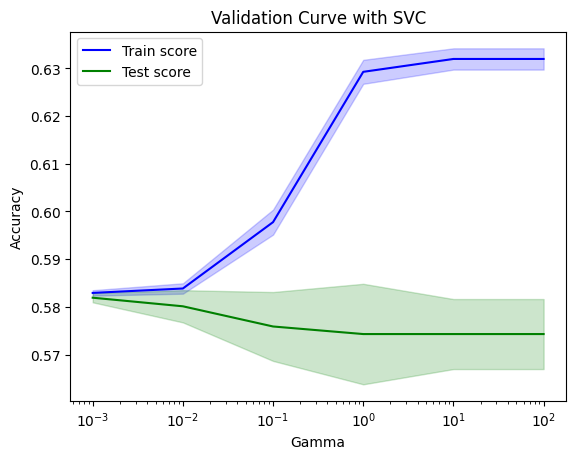

In [53]:
# Çekirdek fonksiyonu için gamma'nın doğruluğunu inceleme
param_range = np.logspace(-3, 2, 6)
train_scores, test_scores = validation_curve(
    svc_model,
    X, y,
    param_name='gamma',
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

# Ortalama doğrulukları hesaplama
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Karmaşıklık analizini çizme
plt.figure()
plt.semilogx(param_range, train_mean, label='Train score', color='blue')
plt.semilogx(param_range, test_mean, label='Test score', color='green')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.title('Validation Curve with SVC')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

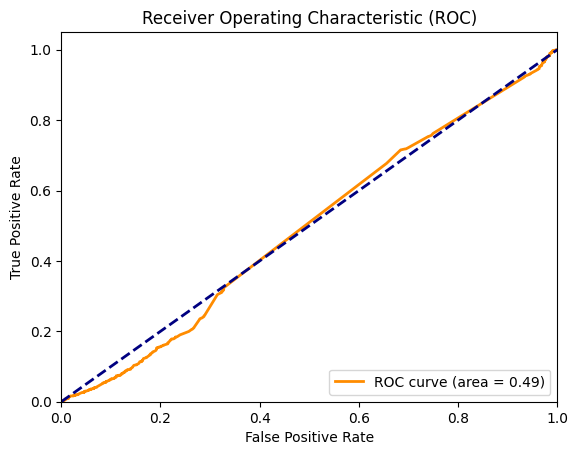

In [54]:
# Modeli tanımlama ve eğitim
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)

# Tahmin olasılıkları
y_prob = svc_model.predict_proba(X_test)[:, 1]

# ROC eğrisi verileri
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [55]:
# Erken Durdurma Uygulaması
# Veriyi eğitim ve doğrulama setlerine ayırma
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelinizi eğitim ve doğrulama setleri ile eğitme
# Basit bir model tanımlama
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Erken Durdurma
early_stopping = EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik
    patience=5,          # Sabırlı bekleme süresi
    min_delta=0.001,     # İyileşme miktarı
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)

# Modeli eğitim ve doğrulama setleri ile eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping]
)

c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5642 - loss: 0.6889 - val_accuracy: 0.5968 - val_loss: 0.6717
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5754 - loss: 0.6790 - val_accuracy: 0.5841 - val_loss: 0.6693
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5732 - loss: 0.6804 - val_accuracy: 0.5778 - val_loss: 0.6786
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5773 - loss: 0.6805 - val_accuracy: 0.5847 - val_loss: 0.6708
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5697 - loss: 0.6795 - val_accuracy: 0.5868 - val_loss: 0.6688
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5589 - loss: 0.6790 - val_accuracy: 0.5746 - val_loss: 0.6733
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5764 - loss: 0.6758 - val_accuracy: 0.5862 - val_loss: 0.6700


In [56]:
# Test seti tahminleri
y_test_pred_prob = model.predict(X_test)  # Tahminler sürekli değerler
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Eşik değerini 0.5 olarak kullanarak ikili sınıflara dönüştürme

# Doğruluk skoru
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Seti Doğruluk Skoru: {accuracy:.4f}")

# Diğer performans metrikleri
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_test_pred))

# Karışıklık Matrisi
print("Karışıklık Matrisi:")
print(confusion_matrix(y_test, y_test_pred))

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Seti Doğruluk Skoru: 0.5785
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.49      0.18      0.26      1182
           1       0.60      0.86      0.70      1653

    accuracy                           0.58      2835
   macro avg       0.54      0.52      0.48      2835
weighted avg       0.55      0.58      0.52      2835

Karışıklık Matrisi:
[[ 214  968]
 [ 227 1426]]


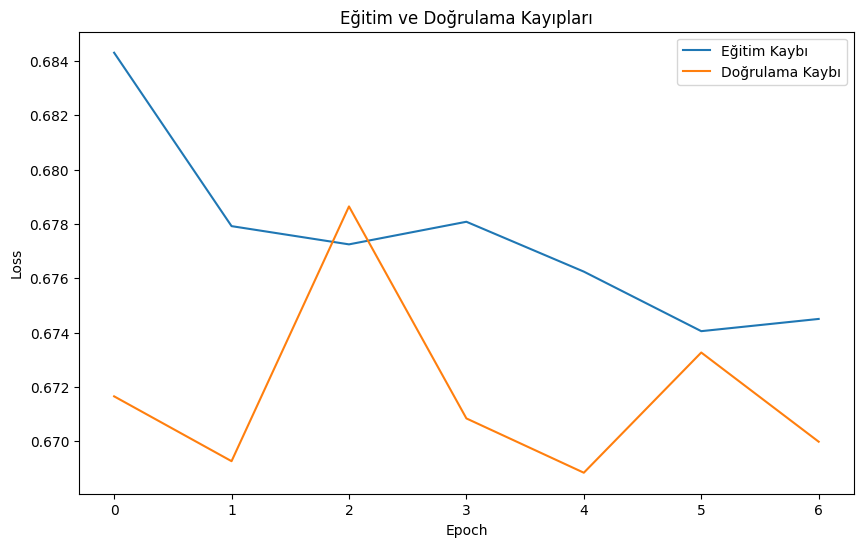

In [57]:
# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.show()

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


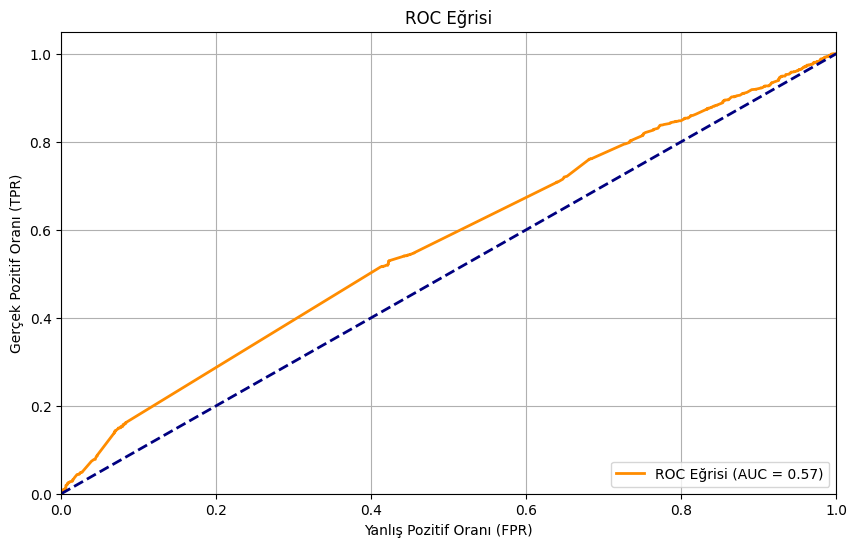

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Olasılık tahminlerini alma
y_test_prob = model.predict(X_test).ravel()  # predict() döndürülen sonuçları 1D diziye dönüştürme

# ROC eğrisini ve AUC'yi hesaplama
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auc = roc_auc_score(y_test, y_test_prob)

# ROC eğrisini çizme
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Gerçek Pozitif Oranı (TPR)')
plt.title('ROC Eğrisi')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Zamansal Trendler: Yıllar içinde başarılar ve performans nasıl değişmiş?

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11691 entries, 0 to 11690
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Person ID               11691 non-null  object
 1   Yıl(Güncellenmiş)       11691 non-null  object
 2   Akademik Personel Tipi  11691 non-null  object
 3   Cinsiyet Bilgisi        11691 non-null  object
 4   Ödüller                 11691 non-null  int64 
 5   Sunduğu bildiriler      11691 non-null  int64 
 6   Yayınlanmış makale      11691 non-null  int64 
 7   Aldığı atıflar          11691 non-null  int64 
 8   Kitap yazımı            11691 non-null  int64 
 9   Yaptığı editörlükler    11691 non-null  int64 
 10  Yönetilen tezler        11691 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1004.8+ KB


In [60]:
# İlk veri setinden temizlenmiş veri oluşturma
df_year = df.copy()

# Ödüller için özel sınırlar
valid_awards = (df_year['Ödüller'] >= 0) & (df_year['Ödüller'] <= 5)
df_year = df_year[valid_awards]

# Bildiri Sunma için sınır
valid_presentations = (df_year['Sunduğu bildiriler'] >= 0) & (df_year['Sunduğu bildiriler'] <= 20)
df_year = df_year[valid_presentations]

# Makale Yayınlama için sınır
valid_publications = (df_year['Yayınlanmış makale'] >= 0) & (df_year['Yayınlanmış makale'] <= 10)
df_year = df_year[valid_publications]

# Atıf için sınır
valid_citations = (df_year['Aldığı atıflar'] >= 0) & (df_year['Aldığı atıflar'] <= 100)
df_year = df_year[valid_citations]

# Kitap Yazma için sınır
valid_books = df_year['Kitap yazımı'] < 5
df_year = df_year[valid_books]

# Editörlük için sınır
valid_editorship = (df_year['Yaptığı editörlükler'] >= 0) & (df_year['Yaptığı editörlükler'] <= 5)
df_year = df_year[valid_editorship]

# Tez Yönetimi için sınır
valid_thesis_supervision = (df_year['Yönetilen tezler'] >= 0) & (df_year['Yönetilen tezler'] <= 10)
df_year = df_year[valid_thesis_supervision]

In [61]:
df_year.describe()

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
count,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000
mean,0.070825,1.521590,1.907928,1.949737,0.317455,0.071282,0.299863
std,0.355160,3.297615,2.123723,5.454734,0.768302,0.380539,0.919337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,20.000000,10.000000,62.000000,4.000000,5.000000,10.000000


In [62]:
# Hata kontrolü için kategorik veri içeren sütunların benzersiz değerlerinin görüntülenmesi
# Benzersiz değerlerin listesi

unique_values_person = map(str,df_year['Person ID'].unique())
unique_values_personel = df_year['Akademik Personel Tipi'].unique()
unique_values_cinsiyet = df_year['Cinsiyet Bilgisi'].unique()
unique_values_yil = df_year['Yıl(Güncellenmiş)'].unique()

# Tabloyu oluşturma
output = f"""
Benzersiz Değerler Tablosu:

Person ID:
{textwrap.fill(', '.join(unique_values_person), width=800)}

Akademik Personel Tipi:
{', '.join(unique_values_personel)}

Cinsiyet:
{', '.join(unique_values_cinsiyet)}

Yıl:
{textwrap.fill(', '.join(unique_values_yil), width=180)}

"""

print(output)


Benzersiz Değerler Tablosu:

Person ID:
124, 276, 285, 294, 295, 296, 301, 302, 304, 308, 311, 312, 313, 316, 317, 341, 345, 347, 371, 375, 396, 399, 400, 401, 406, 417, 418, 420, 443, 444, 445, 447, 449, 452, 453, 454, 459, 460, 461, 462, 465, 466, 468, 469, 478, 484, 488, 493, 496, 497, 499, 500, 506, 507, 508, 509, 510, 511, 513, 533, 535, 537, 538, 539, 540, 541, 542, 546, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 566, 567, 568, 569, 572, 573, 576, 581, 585, 589, 593, 596, 597, 602, 603, 605, 606, 614, 618, 619, 621, 638, 639, 642, 643, 706, 718, 1084, 1102, 1106, 1107, 1110, 1111, 1112, 1113, 1115, 1116, 1118, 1119, 1124, 1125, 1130, 1160, 1189, 1198, 1200, 1202, 1211, 1219, 1221, 1309, 1310, 1311, 1314, 1315, 1316, 1322, 1323, 1324, 1325, 1331, 1344, 1362, 1382, 1384, 1390, 1404, 1407,
1413, 1417, 1445, 1473, 1480, 1497, 1500, 1503, 1526, 1530, 1534, 1536, 1540, 1543, 1548, 1550, 1552, 1558, 1560, 1562, 1564, 1567, 1572, 1575, 1577, 1578, 1592, 1

In [63]:
# Üzerinde incelene yapılmayacak sütunları kaldırma
df_year = df_year.drop(columns=['Akademik Personel Tipi', 'Person ID', 'Cinsiyet Bilgisi']) #################################'Person ID', 

In [64]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8754 entries, 0 to 11689
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Yıl(Güncellenmiş)     8754 non-null   object
 1   Ödüller               8754 non-null   int64 
 2   Sunduğu bildiriler    8754 non-null   int64 
 3   Yayınlanmış makale    8754 non-null   int64 
 4   Aldığı atıflar        8754 non-null   int64 
 5   Kitap yazımı          8754 non-null   int64 
 6   Yaptığı editörlükler  8754 non-null   int64 
 7   Yönetilen tezler      8754 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 615.5+ KB


In [65]:
# Yıl sütununu datetime formatına dönüştür
df_year['Yıl(Güncellenmiş)'] = pd.to_datetime(df_year['Yıl(Güncellenmiş)'], format='%Y', errors='coerce')

In [66]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8754 entries, 0 to 11689
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Yıl(Güncellenmiş)     8752 non-null   datetime64[ns]
 1   Ödüller               8754 non-null   int64         
 2   Sunduğu bildiriler    8754 non-null   int64         
 3   Yayınlanmış makale    8754 non-null   int64         
 4   Aldığı atıflar        8754 non-null   int64         
 5   Kitap yazımı          8754 non-null   int64         
 6   Yaptığı editörlükler  8754 non-null   int64         
 7   Yönetilen tezler      8754 non-null   int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 615.5 KB


In [67]:
missing_values_sutun = df_year.isna().sum()

print(f"Eksik veri sayısı: {missing_values_sutun}")

Eksik veri sayısı: Yıl(Güncellenmiş)       2
Ödüller                 0
Sunduğu bildiriler      0
Yayınlanmış makale      0
Aldığı atıflar          0
Kitap yazımı            0
Yaptığı editörlükler    0
Yönetilen tezler        0
dtype: int64


In [68]:
# Eksik değerlerini içeren satırları veri çerçevesinden kaldır
df_year = df_year.dropna(subset=['Yıl(Güncellenmiş)'])

# Bilgileri kontrol et
missing_values_sutun1 = df_year.isna().sum()
print(f"Eksik veri sayısı: {missing_values_sutun1}")

Eksik veri sayısı: Yıl(Güncellenmiş)       0
Ödüller                 0
Sunduğu bildiriler      0
Yayınlanmış makale      0
Aldığı atıflar          0
Kitap yazımı            0
Yaptığı editörlükler    0
Yönetilen tezler        0
dtype: int64


In [69]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8752 entries, 0 to 11689
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Yıl(Güncellenmiş)     8752 non-null   datetime64[ns]
 1   Ödüller               8752 non-null   int64         
 2   Sunduğu bildiriler    8752 non-null   int64         
 3   Yayınlanmış makale    8752 non-null   int64         
 4   Aldığı atıflar        8752 non-null   int64         
 5   Kitap yazımı          8752 non-null   int64         
 6   Yaptığı editörlükler  8752 non-null   int64         
 7   Yönetilen tezler      8752 non-null   int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 615.4 KB


In [70]:
# Yıl sütununu indeks olarak ayarlama
df_year.set_index('Yıl(Güncellenmiş)', inplace=True)  # Yıl sütununu index olarak ayarlama

In [71]:
df_year.index = pd.to_datetime(df_year.index)

In [72]:
df_year

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
Yıl(Güncellenmiş),,,,,,,
2016-01-01,0,2,1,0,0,0,0
2017-01-01,0,3,8,0,2,0,0
2018-01-01,0,3,1,0,0,0,0
2019-01-01,0,0,5,0,0,0,0
2019-01-01,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2017-01-01,0,4,0,0,0,0,0
2018-01-01,0,10,1,0,0,0,0
2019-01-01,0,1,0,0,0,0,0


In [73]:
# Her yıl için ortalama başarı metriklerini hesaplama
# Kategorik sütunları veri çerçevesinden çıkar
numeric_df = df_year.select_dtypes(include=['number'])
annual_metrics = numeric_df.resample('Y').mean()  # Yıllık ortalama hesaplama

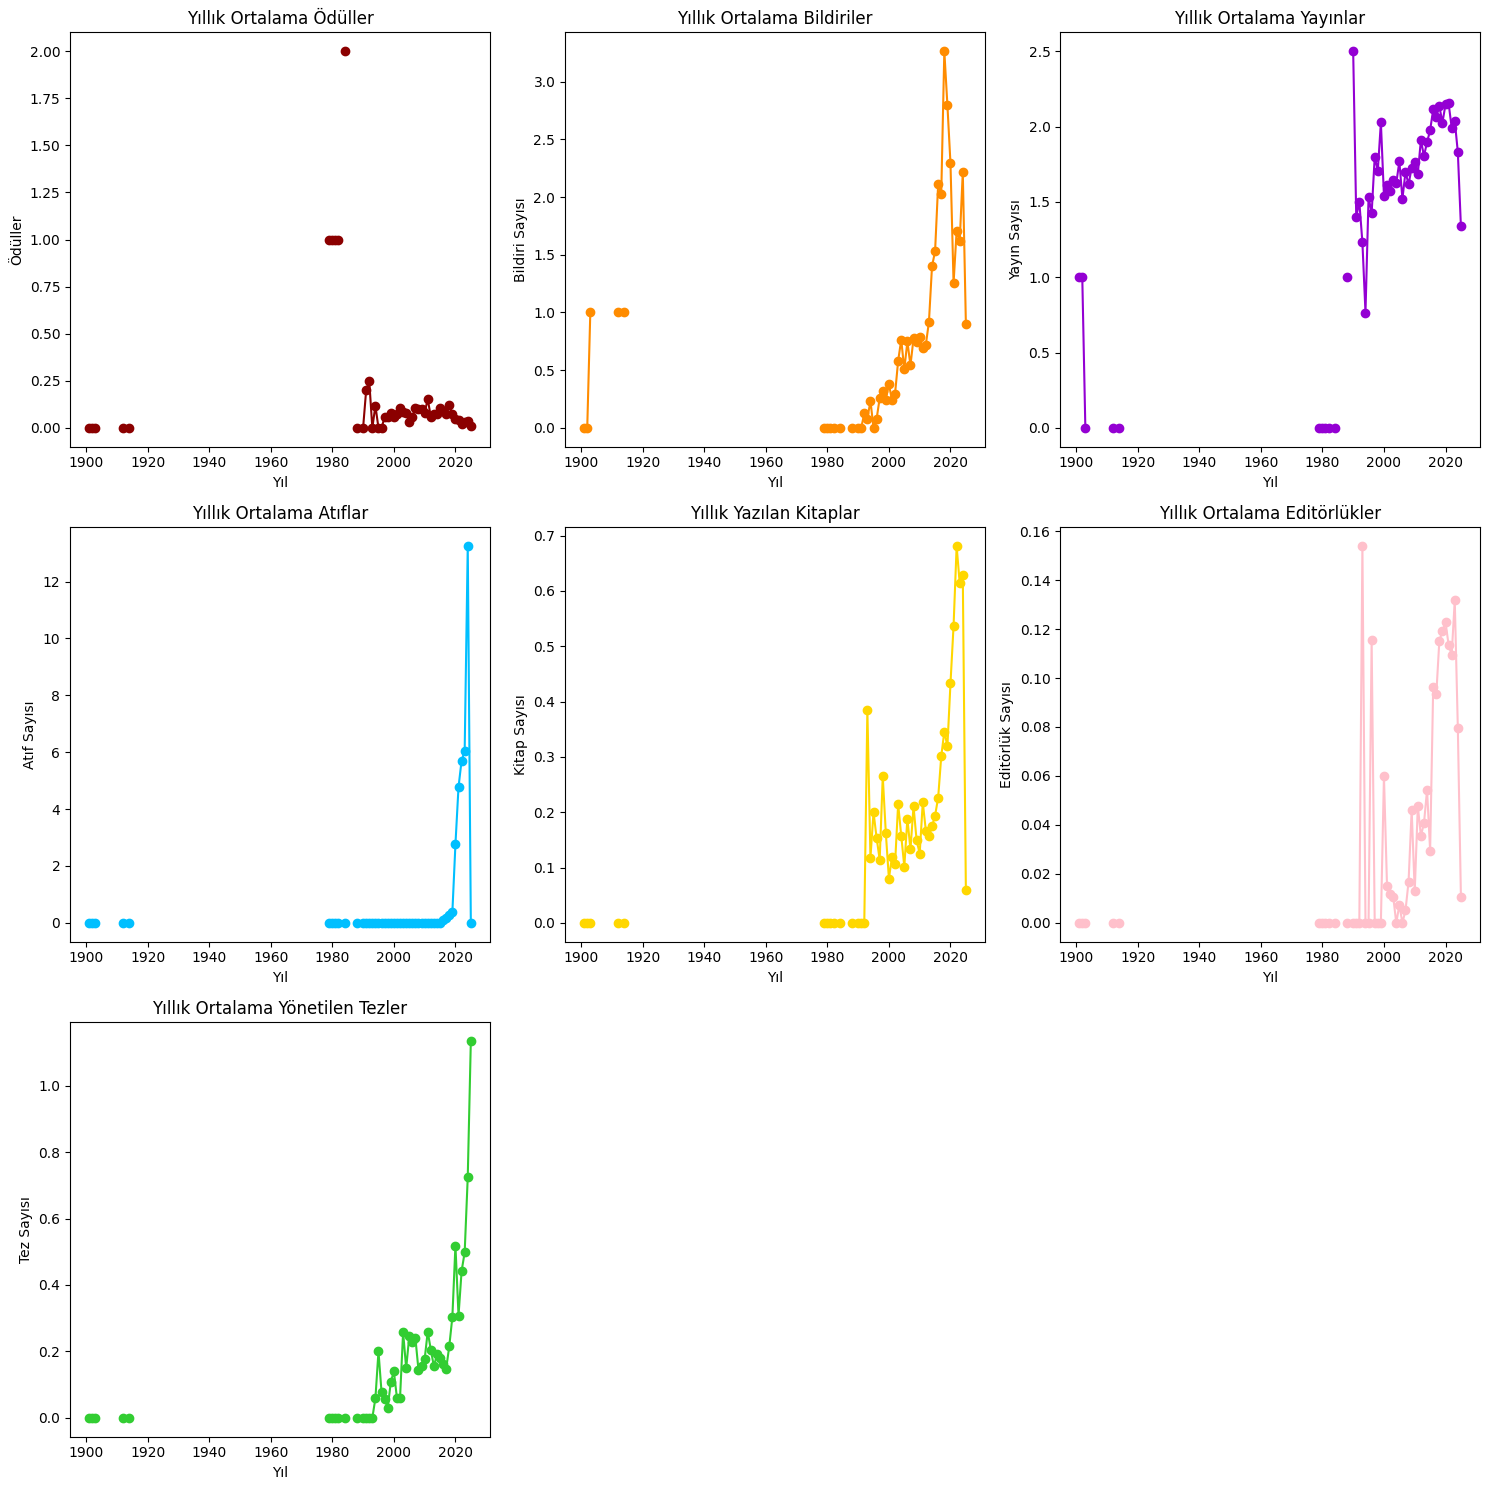

In [74]:
# Grafiklerin oluşturulması
plt.figure(figsize=(15, 15))

# Ödüller grafiği
plt.subplot(3, 3, 1)
plt.plot(annual_metrics.index, annual_metrics['Ödüller'], marker='o', linestyle='-', color='darkred')
plt.title('Yıllık Ortalama Ödüller')
plt.xlabel('Yıl')
plt.ylabel('Ödüller')

# Bildiriler grafiği
plt.subplot(3, 3, 2)
plt.plot(annual_metrics.index, annual_metrics['Sunduğu bildiriler'], marker='o', linestyle='-', color='darkorange')
plt.title('Yıllık Ortalama Bildiriler')
plt.xlabel('Yıl')
plt.ylabel('Bildiri Sayısı')

# Yayınlar grafiği
plt.subplot(3, 3, 3)
plt.plot(annual_metrics.index, annual_metrics['Yayınlanmış makale'], marker='o', linestyle='-', color='darkviolet')
plt.title('Yıllık Ortalama Yayınlar')
plt.xlabel('Yıl')
plt.ylabel('Yayın Sayısı')

# Atıflar grafiği
plt.subplot(3, 3, 4)
plt.plot(annual_metrics.index, annual_metrics['Aldığı atıflar'], marker='o', linestyle='-', color='deepskyblue')
plt.title('Yıllık Ortalama Atıflar')
plt.xlabel('Yıl')
plt.ylabel('Atıf Sayısı')

# Kitaplar grafiği
plt.subplot(3, 3, 5)
plt.plot(annual_metrics.index, annual_metrics['Kitap yazımı'], marker='o', linestyle='-', color='gold')
plt.title('Yıllık Yazılan Kitaplar')
plt.xlabel('Yıl')
plt.ylabel('Kitap Sayısı')

# Editörlükler grafiği
plt.subplot(3, 3, 6)
plt.plot(annual_metrics.index, annual_metrics['Yaptığı editörlükler'], marker='o', linestyle='-', color='pink')
plt.title('Yıllık Ortalama Editörlükler')
plt.xlabel('Yıl')
plt.ylabel('Editörlük Sayısı')

# Tezler grafiği
plt.subplot(3, 3, 7)
plt.plot(annual_metrics.index, annual_metrics['Yönetilen tezler'], marker='o', linestyle='-', color='limegreen')
plt.title('Yıllık Ortalama Yönetilen Tezler')
plt.xlabel('Yıl')
plt.ylabel('Tez Sayısı')

# Boş kalan subplot'ları temizle
plt.subplot(3, 3, 8).axis('off')
plt.subplot(3, 3, 9).axis('off')

plt.tight_layout()
plt.show()

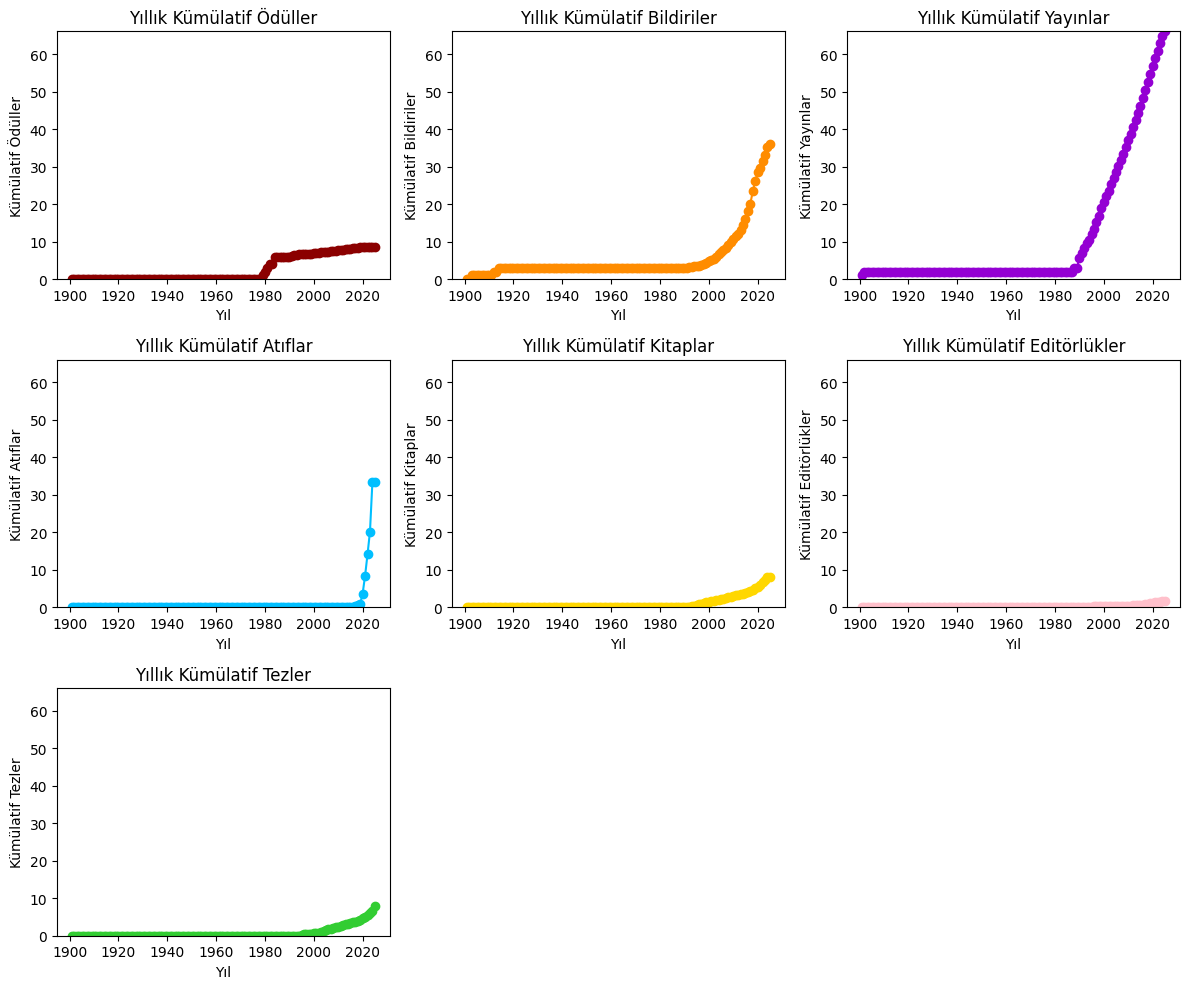

In [75]:
# Kümülatif Toplamların Hesaplanması
# Yıllık başarı metriklerinin kümülatif toplamlarının hesaplanması
cumulative_metrics = annual_metrics.resample('Y').sum().cumsum()

# Y ekseninin aralığını belirlemek için tüm kümülatif metriklerin maksimum ve minimum değerlerini hesaplama
min_y = cumulative_metrics.min().min()
max_y = cumulative_metrics.max().max()

# Grafiklerin oluşturulması
plt.figure(figsize=(12, 10))

# Ödüller grafiği
plt.subplot(3, 3, 1)
plt.plot(cumulative_metrics.index, cumulative_metrics['Ödüller'], marker='o', linestyle='-', color='darkred')
plt.title('Yıllık Kümülatif Ödüller')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Ödüller')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Bildiriler grafiği
plt.subplot(3, 3, 2)
plt.plot(cumulative_metrics.index, cumulative_metrics['Sunduğu bildiriler'], marker='o', linestyle='-', color='darkorange')
plt.title('Yıllık Kümülatif Bildiriler')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Bildiriler')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Yayınlar grafiği
plt.subplot(3, 3, 3)
plt.plot(cumulative_metrics.index, cumulative_metrics['Yayınlanmış makale'], marker='o', linestyle='-', color='darkviolet')
plt.title('Yıllık Kümülatif Yayınlar')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Yayınlar')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Atıflar grafiği
plt.subplot(3, 3, 4)
plt.plot(cumulative_metrics.index, cumulative_metrics['Aldığı atıflar'], marker='o', linestyle='-', color='deepskyblue')
plt.title('Yıllık Kümülatif Atıflar')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Atıflar')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Kitaplar grafiği
plt.subplot(3, 3, 5)
plt.plot(cumulative_metrics.index, cumulative_metrics['Kitap yazımı'], marker='o', linestyle='-', color='gold')
plt.title('Yıllık Kümülatif Kitaplar')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Kitaplar')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Editörlükler grafiği
plt.subplot(3, 3, 6)
plt.plot(cumulative_metrics.index, cumulative_metrics['Yaptığı editörlükler'], marker='o', linestyle='-', color='pink')
plt.title('Yıllık Kümülatif Editörlükler')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Editörlükler')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

# Tezler grafiği
plt.subplot(3, 3, 7)
plt.plot(cumulative_metrics.index, cumulative_metrics['Yönetilen tezler'], marker='o', linestyle='-', color='limegreen')
plt.title('Yıllık Kümülatif Tezler')
plt.xlabel('Yıl')
plt.ylabel('Kümülatif Tezler')
plt.ylim(min_y, max_y)  # Aynı y ekseni sınırlarını uygulama

plt.tight_layout()
plt.show()

In [76]:
df_year = df_year[df_year.index.year >= 1980]

In [77]:
df_year

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
Yıl(Güncellenmiş),,,,,,,
2016-01-01,0,2,1,0,0,0,0
2017-01-01,0,3,8,0,2,0,0
2018-01-01,0,3,1,0,0,0,0
2019-01-01,0,0,5,0,0,0,0
2019-01-01,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2017-01-01,0,4,0,0,0,0,0
2018-01-01,0,10,1,0,0,0,0
2019-01-01,0,1,0,0,0,0,0


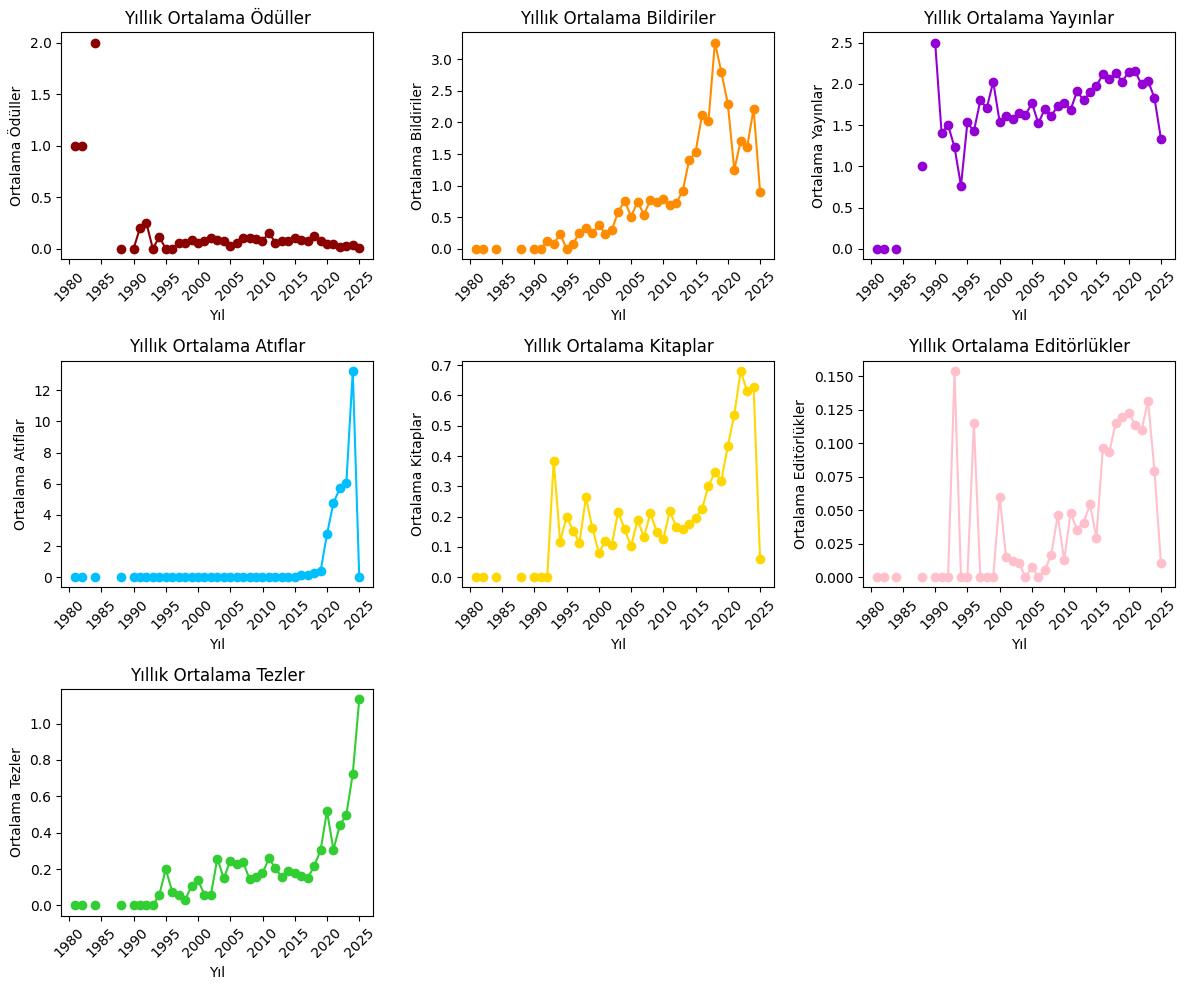

In [78]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Yıllık ortalama başarı metriklerinin hesaplanması
annual_means = df_year.resample('Y').mean()

# Grafiklerin oluşturulması
plt.figure(figsize=(12, 10))

# Ödüller grafiği
plt.subplot(3, 3, 1)
plt.plot(annual_means.index, annual_means['Ödüller'], marker='o', linestyle='-', color='darkred')
plt.title('Yıllık Ortalama Ödüller')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Ödüller')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Yıl olarak formatla
plt.xticks(rotation=45)

# Bildiriler grafiği
plt.subplot(3, 3, 2)
plt.plot(annual_means.index, annual_means['Sunduğu bildiriler'], marker='o', linestyle='-', color='darkorange')
plt.title('Yıllık Ortalama Bildiriler')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Bildiriler')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Yıl olarak formatla
plt.xticks(rotation=45)

# Yayınlar grafiği
plt.subplot(3, 3, 3)
plt.plot(annual_means.index, annual_means['Yayınlanmış makale'], marker='o', linestyle='-', color='darkviolet')
plt.title('Yıllık Ortalama Yayınlar')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Yayınlar')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Yıl olarak formatla
plt.xticks(rotation=45)

# Atıflar grafiği
plt.subplot(3, 3, 4)
plt.plot(annual_means.index, annual_means['Aldığı atıflar'], marker='o', linestyle='-', color='deepskyblue')
plt.title('Yıllık Ortalama Atıflar')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Atıflar')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Yıl olarak formatla
plt.xticks(rotation=45)

# Kitaplar grafiği
plt.subplot(3, 3, 5)
plt.plot(annual_means.index, annual_means['Kitap yazımı'], marker='o', linestyle='-', color='gold')
plt.title('Yıllık Ortalama Kitaplar')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Kitaplar')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Yıl olarak formatla
plt.xticks(rotation=45)

# Editörlükler grafiği
plt.subplot(3, 3, 6)
plt.plot(annual_means.index, annual_means['Yaptığı editörlükler'], marker='o', linestyle='-', color='pink')
plt.title('Yıllık Ortalama Editörlükler')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Editörlükler')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Yıl olarak formatla
plt.xticks(rotation=45)

# Tezler grafiği
plt.subplot(3, 3, 7)
plt.plot(annual_means.index, annual_means['Yönetilen tezler'], marker='o', linestyle='-', color='limegreen')
plt.title('Yıllık Ortalama Tezler')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Tezler')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Yıl olarak formatla
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [79]:
# Hareketli Ortalama hesaplama (12 aylık hareketli ortalama)
metrics = ['Ödüller', 'Sunduğu bildiriler', 'Yayınlanmış makale', 'Aldığı atıflar', 'Kitap yazımı', 'Yaptığı editörlükler', 'Yönetilen tezler']

for metric in metrics:
    df_year[f'{metric} Hareketli Ortalama'] = df_year[metric].rolling(window=12).mean()


C:\Users\elift\AppData\Local\Temp\ipykernel_11692\14193106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year[f'{metric} Hareketli Ortalama'] = df_year[metric].rolling(window=12).mean()
C:\Users\elift\AppData\Local\Temp\ipykernel_11692\14193106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year[f'{metric} Hareketli Ortalama'] = df_year[metric].rolling(window=12).mean()
C:\Users\elift\AppData\Local\Temp\ipykernel_11692\14193106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

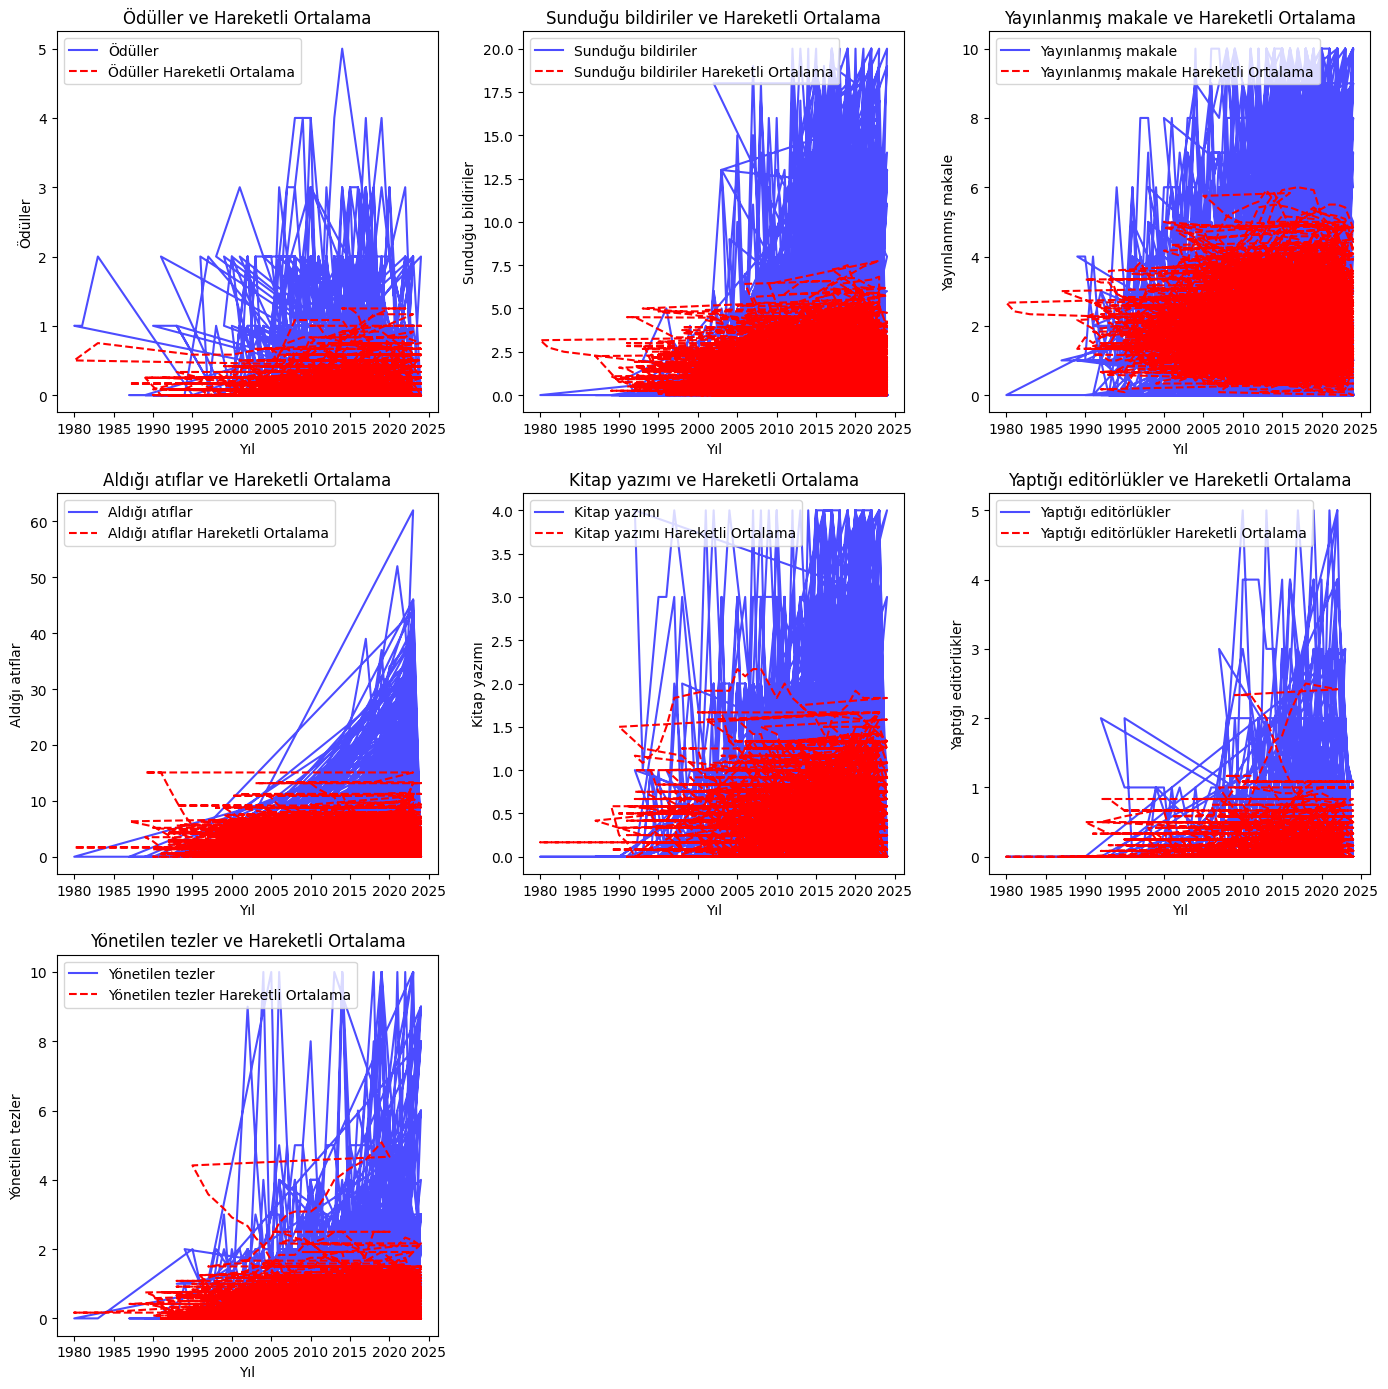

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))

# Grafiklerin oluşturulması
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    plt.plot(df_year.index, df_year[metric], label=f'{metric}', color='blue', alpha=0.7)
    plt.plot(df_year.index, df_year[f'{metric} Hareketli Ortalama'], label=f'{metric} Hareketli Ortalama', color='red', linestyle='--')
    plt.title(f'{metric} ve Hareketli Ortalama')
    plt.xlabel('Yıl')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


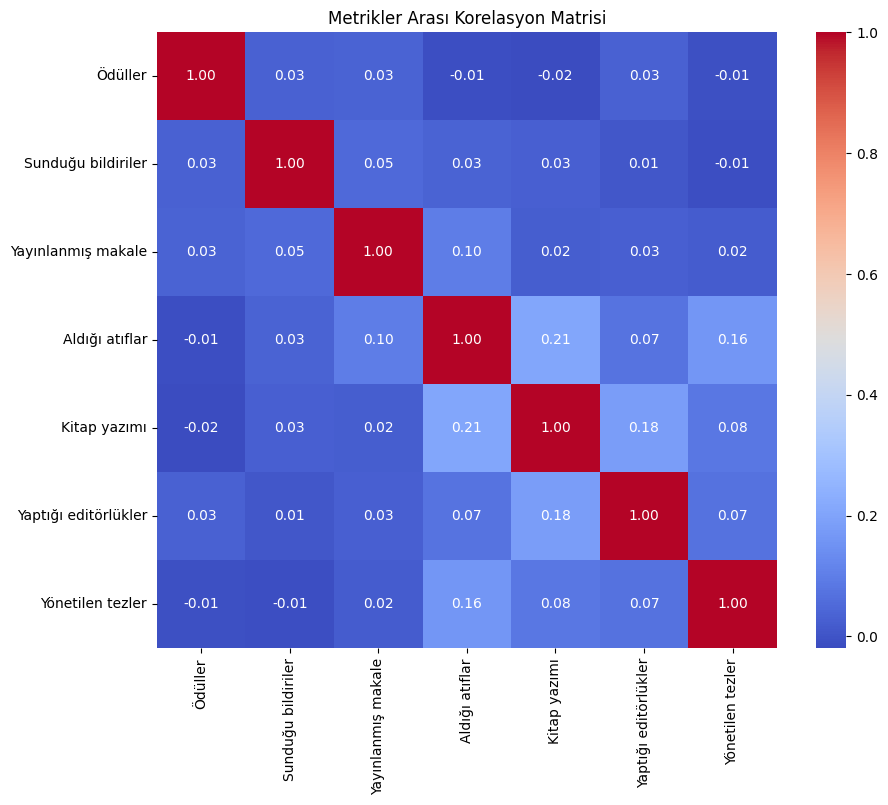

In [81]:
# Korelasyon matrisini hesapla
correlation_matrix = df_year[metrics].corr()

# Korelasyon matrisini görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Metrikler Arası Korelasyon Matrisi')
plt.show()

In [82]:
df_year = df_year.dropna(axis=1, how='any')

In [83]:
df_year

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
Yıl(Güncellenmiş),,,,,,,
2016-01-01,0,2,1,0,0,0,0
2017-01-01,0,3,8,0,2,0,0
2018-01-01,0,3,1,0,0,0,0
2019-01-01,0,0,5,0,0,0,0
2019-01-01,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2017-01-01,0,4,0,0,0,0,0
2018-01-01,0,10,1,0,0,0,0
2019-01-01,0,1,0,0,0,0,0


In [84]:
# Sıfır olan değerlerin kontrolü için koşul oluşturma
condition = (
    (df_year['Sunduğu bildiriler'] == 0) &
    (df_year['Yayınlanmış makale'] == 0) &
    (df_year['Aldığı atıflar'] == 0) &
    (df_year['Kitap yazımı'] == 0) &
    (df_year['Yaptığı editörlükler'] == 0) &
    (df_year['Yönetilen tezler'] == 0)
)

In [85]:
# Koşulu sağlayan satırların sayısını hesaplama
num_zero_rows = condition.sum()

print(f"Sıfır değer içeren satırların sayısı: {num_zero_rows}")


Sıfır değer içeren satırların sayısı: 98


In [86]:
# Bu koşulu sağlayan satırları filtreleyip kaldırma
df_year = df_year[~condition]


In [87]:
df_year

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
Yıl(Güncellenmiş),,,,,,,
2016-01-01,0,2,1,0,0,0,0
2017-01-01,0,3,8,0,2,0,0
2018-01-01,0,3,1,0,0,0,0
2019-01-01,0,0,5,0,0,0,0
2019-01-01,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2017-01-01,0,4,0,0,0,0,0
2018-01-01,0,10,1,0,0,0,0
2019-01-01,0,1,0,0,0,0,0


In [88]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8646 entries, 2016-01-01 to 2022-01-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Ödüller               8646 non-null   int64
 1   Sunduğu bildiriler    8646 non-null   int64
 2   Yayınlanmış makale    8646 non-null   int64
 3   Aldığı atıflar        8646 non-null   int64
 4   Kitap yazımı          8646 non-null   int64
 5   Yaptığı editörlükler  8646 non-null   int64
 6   Yönetilen tezler      8646 non-null   int64
dtypes: int64(7)
memory usage: 540.4 KB


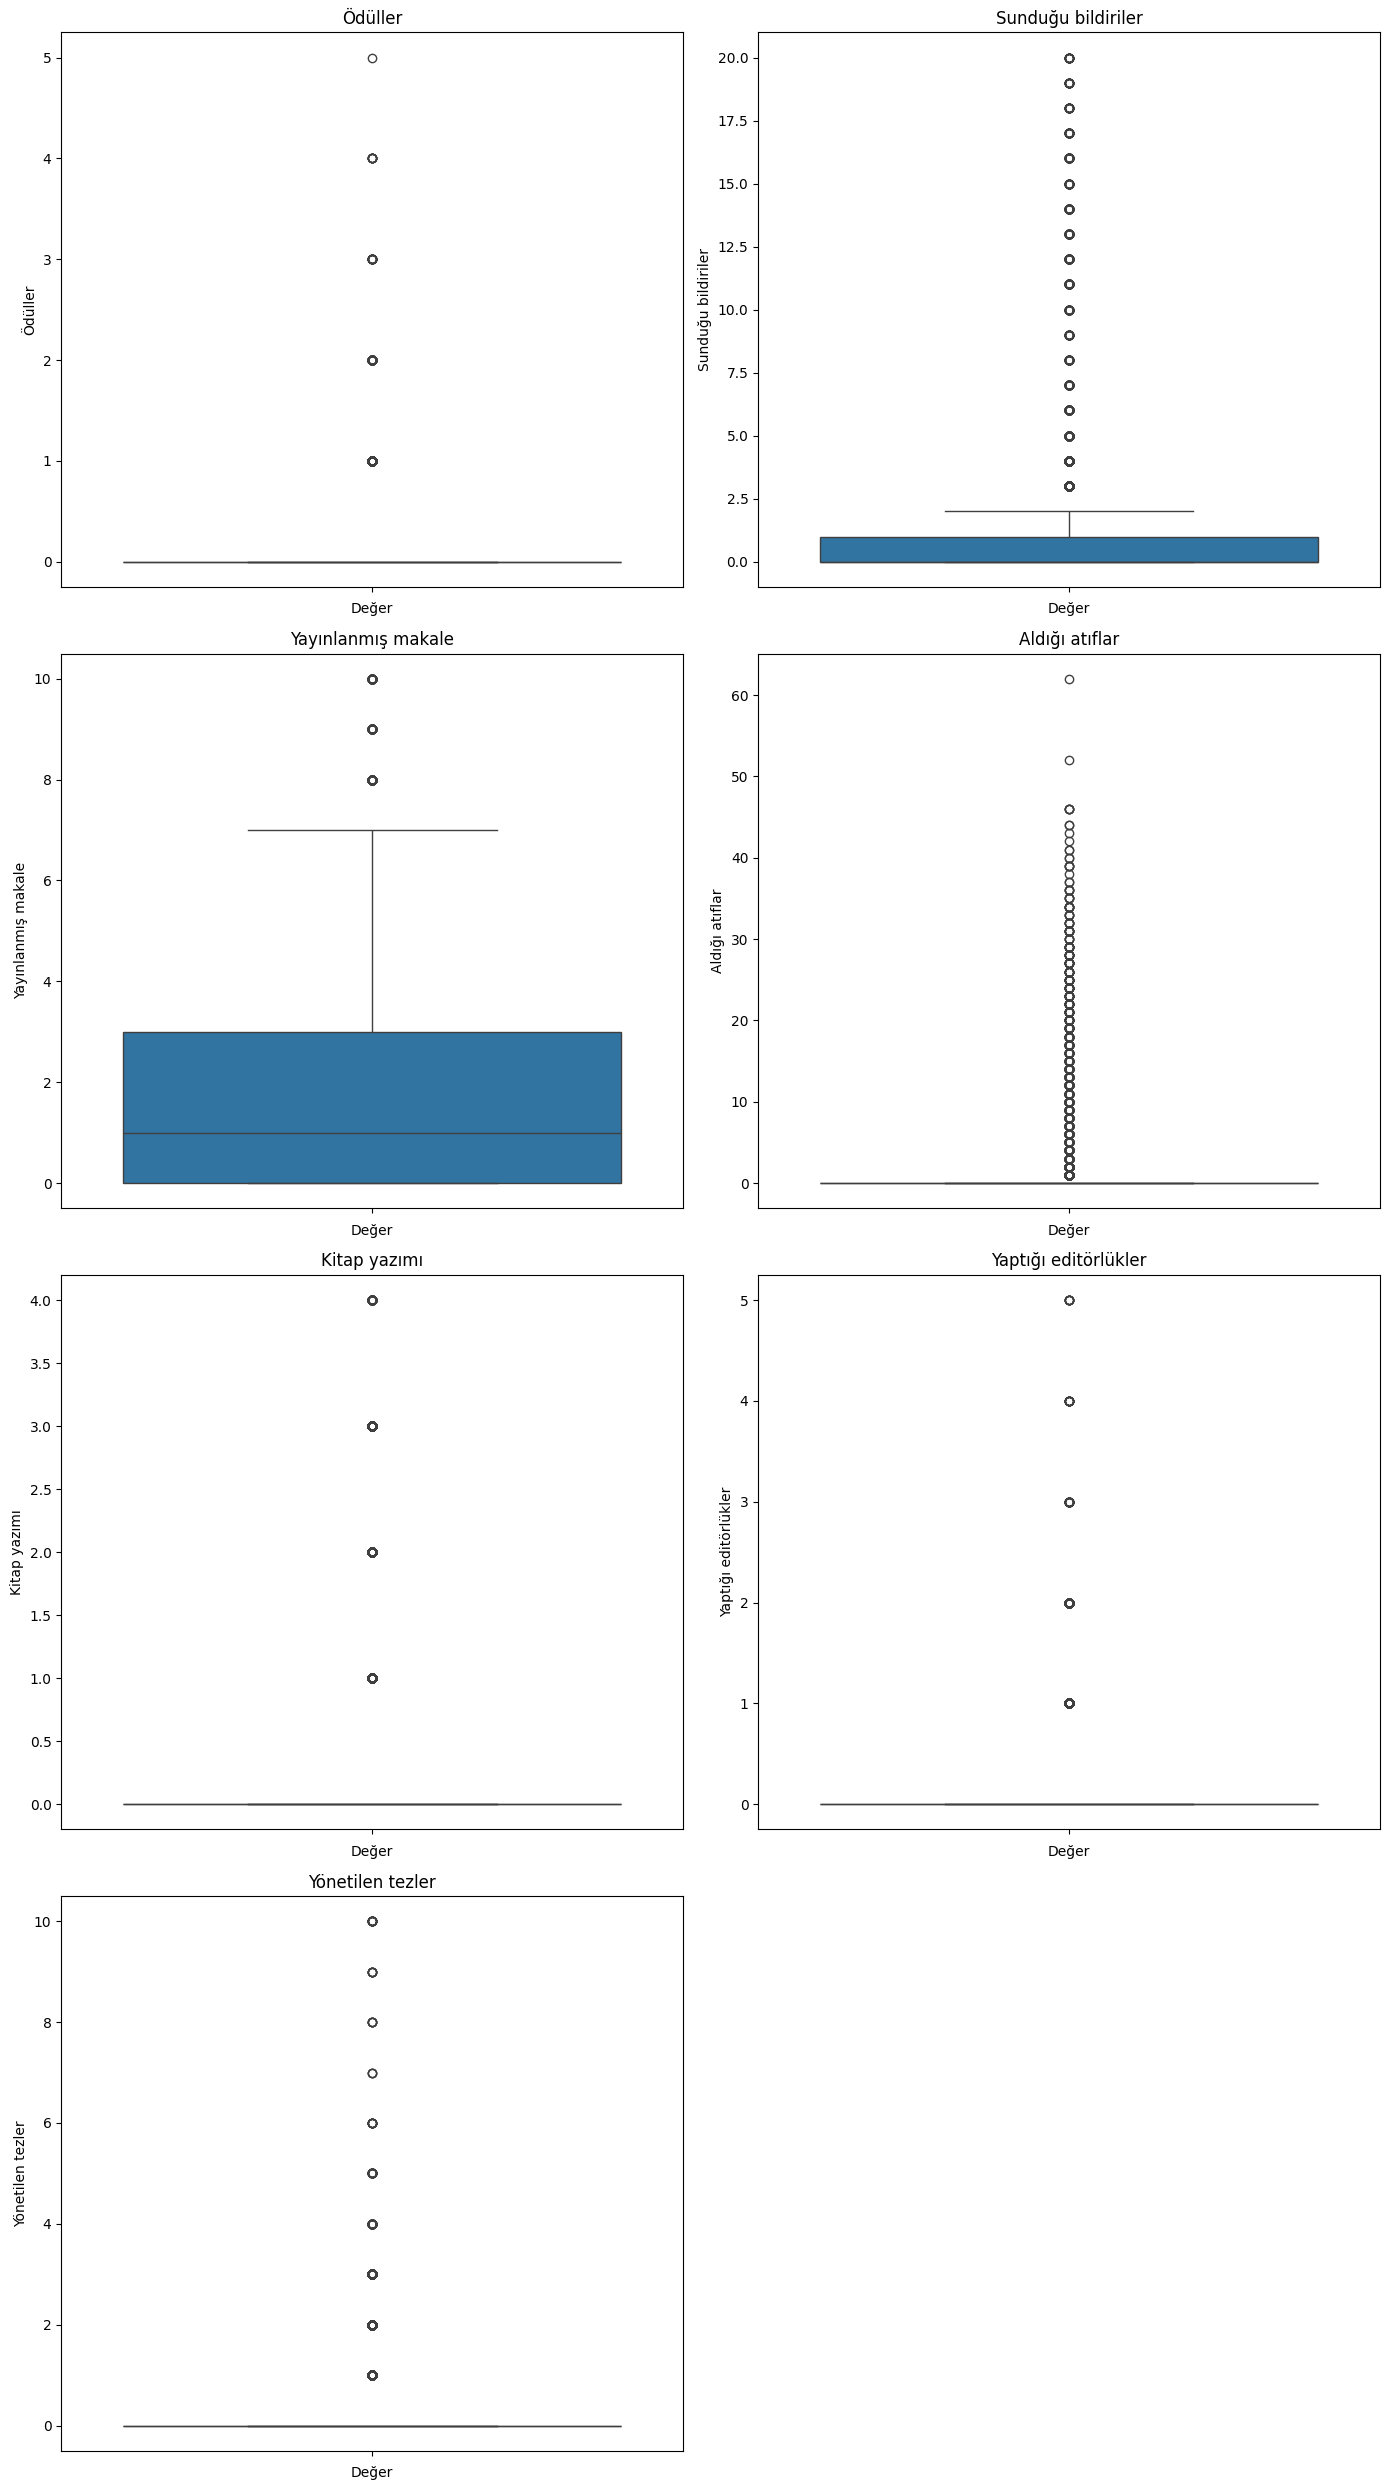

In [89]:
# Grafiklerin boyutlarını ayarlama
plt.figure(figsize=(14, 25))

# Her sütun için subplot oluşturma
n_cols = len(df_year.columns)  # Toplam sütun sayısı
n_rows = (n_cols + 1) // 2  # Satır sayısını hesapla (her satıra 2 sütun olacak şekilde)

for i, column in enumerate(df_year.columns, 1):
    plt.subplot(n_rows, 2, i)  # Satır ve sütun sayısını ayarla
    sns.boxplot(y=df_year[column])
    plt.title(column)
    plt.xlabel('Değer')

plt.tight_layout()  # Alt grafiklerin birbirine çarpmasını önler


In [90]:
# Yıllık ortalama hesaplamak için 'Y' (yıl) ile gruplama yapma
annual_means = df_year.resample('Y').mean()

# Sonuçları kontrol etme
print(annual_means)

                    Ödüller  Sunduğu bildiriler  Yayınlanmış makale  \
Yıl(Güncellenmiş)                                                     
1987-12-31         0.000000            0.000000            1.000000   
1988-12-31              NaN                 NaN                 NaN   
1989-12-31         0.000000            0.000000            2.500000   
1990-12-31         0.000000            0.000000            1.750000   
1991-12-31         0.000000            0.142857            1.714286   
1992-12-31         0.000000            0.076923            1.230769   
1993-12-31         0.000000            0.266667            0.866667   
1994-12-31         0.000000            0.000000            1.533333   
1995-12-31         0.000000            0.076923            1.423077   
1996-12-31         0.057143            0.257143            1.800000   
1997-12-31         0.000000            0.333333            1.757576   
1998-12-31         0.027778            0.250000            2.083333   
1999-1

In [91]:
# NaN değer içeren satırları kaldırma
annual_means_clean = annual_means.dropna()

# Sonuçları kontrol etme
print(annual_means_clean)

                    Ödüller  Sunduğu bildiriler  Yayınlanmış makale  \
Yıl(Güncellenmiş)                                                     
1987-12-31         0.000000            0.000000            1.000000   
1989-12-31         0.000000            0.000000            2.500000   
1990-12-31         0.000000            0.000000            1.750000   
1991-12-31         0.000000            0.142857            1.714286   
1992-12-31         0.000000            0.076923            1.230769   
1993-12-31         0.000000            0.266667            0.866667   
1994-12-31         0.000000            0.000000            1.533333   
1995-12-31         0.000000            0.076923            1.423077   
1996-12-31         0.057143            0.257143            1.800000   
1997-12-31         0.000000            0.333333            1.757576   
1998-12-31         0.027778            0.250000            2.083333   
1999-12-31         0.000000            0.395833            1.604167   
2000-1

In [92]:
annual_means_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 1987-12-31 to 2024-12-31
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ödüller               37 non-null     float64
 1   Sunduğu bildiriler    37 non-null     float64
 2   Yayınlanmış makale    37 non-null     float64
 3   Aldığı atıflar        37 non-null     float64
 4   Kitap yazımı          37 non-null     float64
 5   Yaptığı editörlükler  37 non-null     float64
 6   Yönetilen tezler      37 non-null     float64
dtypes: float64(7)
memory usage: 2.3 KB


In [93]:
annual_means_clean

,Ödüller,Sunduğu bildiriler,Yayınlanmış makale,Aldığı atıflar,Kitap yazımı,Yaptığı editörlükler,Yönetilen tezler
Yıl(Güncellenmiş),,,,,,,
1987-12-31,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1989-12-31,0.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000
1990-12-31,0.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000
1991-12-31,0.000000,0.142857,1.714286,0.000000,0.000000,0.000000,0.000000
1992-12-31,0.000000,0.076923,1.230769,0.000000,0.384615,0.153846,0.000000
1993-12-31,0.000000,0.266667,0.866667,0.000000,0.133333,0.000000,0.066667
1994-12-31,0.000000,0.000000,1.533333,0.000000,0.200000,0.000000,0.200000
1995-12-31,0.000000,0.076923,1.423077,0.000000,0.153846,0.115385,0.076923
1996-12-31,0.057143,0.257143,1.800000,0.000000,0.114286,0.000000,0.057143


In [94]:
result = adfuller(annual_means_clean[column])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 2.1838792697358835
p-value: 0.9988689767954045


In [95]:
df_diff = annual_means_clean.diff().dropna()

In [96]:
result = adfuller(df_diff[column])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.765192088418093
p-value: 6.336746709945135e-05


In [97]:
df_diff_2 = annual_means_clean.diff().diff().dropna()

In [98]:
result = adfuller(df_diff_2[column])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -10.567480580135102
p-value: 7.45203079881386e-19


In [99]:
df_log = np.log(annual_means_clean)
df_log_diff = df_log.diff().dropna()

c:\Users\elift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [100]:
result = adfuller(df_log_diff[column])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.322344646368897
p-value: 0.16486261110505396


In [101]:
df_seasonal_diff = annual_means_clean.diff(periods=12).dropna()  # 12 aylık mevsimsel fark

In [102]:
result = adfuller(df_seasonal_diff[column])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.39589962857224376
p-value: 0.9813409534481735


Çalışmalara df_diff ile devam ediliyor.

In [103]:
y = df_diff[column].values  # Değişkeninizi seçin

In [104]:
# k-fold çapraz doğrulama (cross-validation) 
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 zaman dilimi
mse_scores = []

for train_index, test_index in tscv.split(y):
    train, test = y[train_index], y[test_index]
    
    # Modeli eğitme
    model = auto_arima(train, seasonal=False, trace=False, error_action='ignore', stepwise=True)
    
    # Tahmin yapma
    forecast = model.predict(n_periods=len(test))
    
    # Performansı değerlendirme
    mse = mean_squared_error(test, forecast)
    mse_scores.append(mse)
    
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")
    print(f"Mean Squared Error: {mse}")

print(f"Ortalama MSE: {np.mean(mse_scores)}")


Train indices: [0 1 2 3 4 5]
Test indices: [ 6  7  8  9 10 11]
Mean Squared Error: 0.020016731897351907
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Test indices: [12 13 14 15 16 17]
Mean Squared Error: 0.009998899180752106
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Test indices: [18 19 20 21 22 23]
Mean Squared Error: 0.0038051154969882942
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test indices: [24 25 26 27 28 29]
Mean Squared Error: 0.002131950762320038
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Test indices: [30 31 32 33 34 35]
Mean Squared Error: 0.05565107593849449
Ortalama MSE: 0.01832075465518137


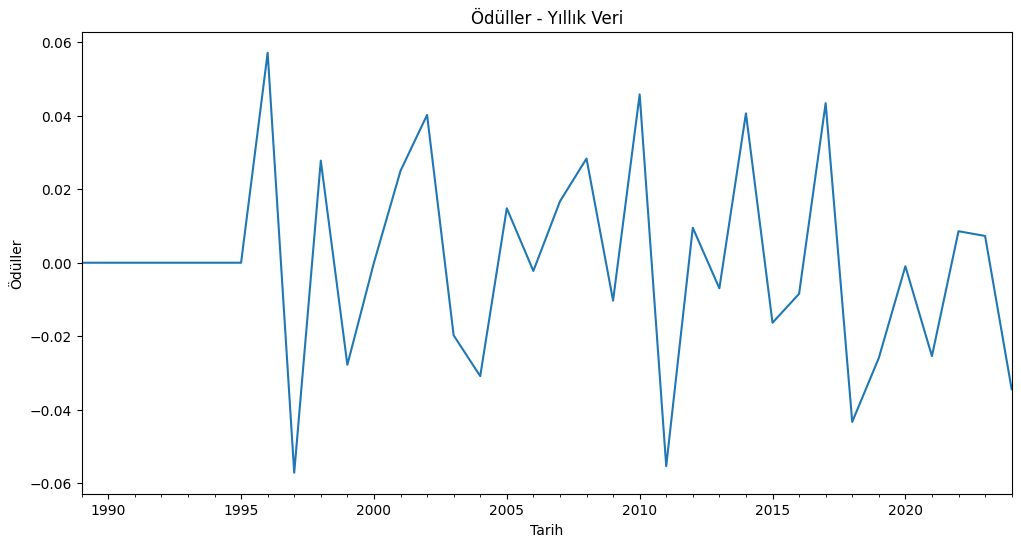

Model Özeti (Ödüller):
                               SARIMAX Results                                
Dep. Variable:                Ödüller   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  82.530
Date:                Mon, 12 Aug 2024   AIC                           -153.060
Time:                        19:45:37   BIC                           -143.559
Sample:                    12-31-1989   HQIC                          -149.744
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.275      0.783      -0.005       0.007
ar.L1          0.3427      1.665      0.206      0.837      -2.920       3.605
ar.L2          0.2401      0.

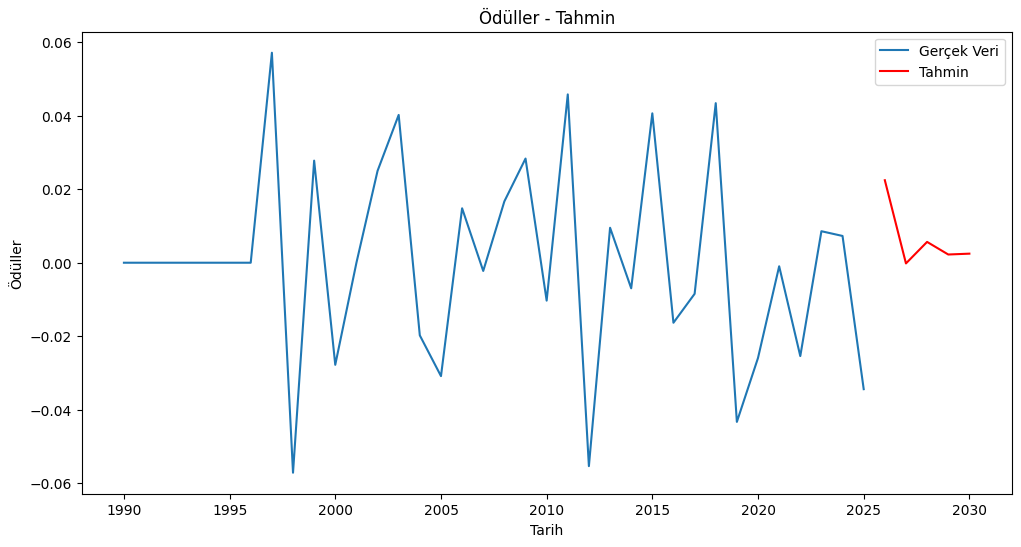

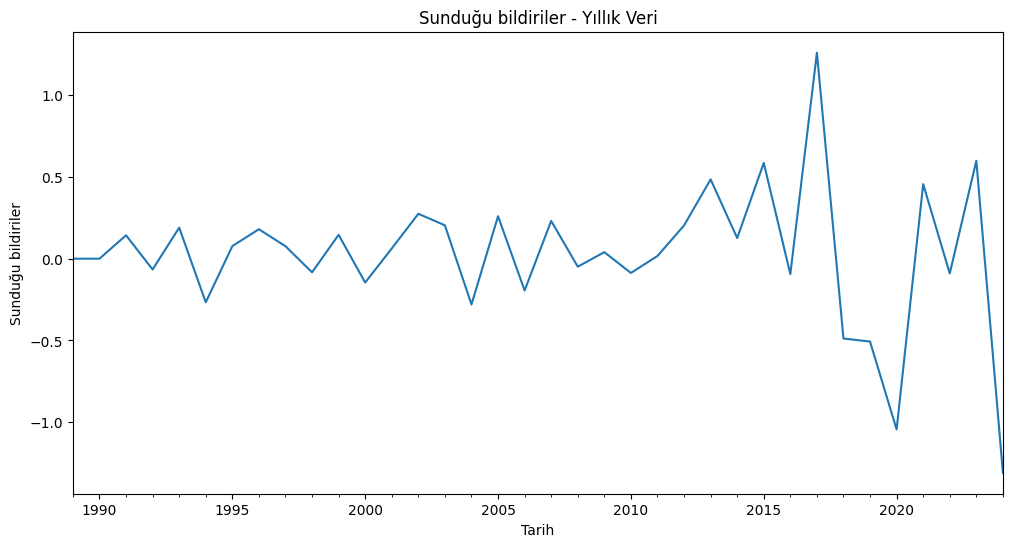

Model Özeti (Sunduğu bildiriler):
                               SARIMAX Results                                
Dep. Variable:     Sunduğu bildiriler   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -14.128
Date:                Mon, 12 Aug 2024   AIC                             40.255
Time:                        19:45:38   BIC                             49.756
Sample:                    12-31-1989   HQIC                            43.571
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0302      0.083      0.365      0.715      -0.132       0.193
ar.L1         -1.7238      0.401     -4.303      0.000      -2.509      -0.939
ar.L2         -0.7

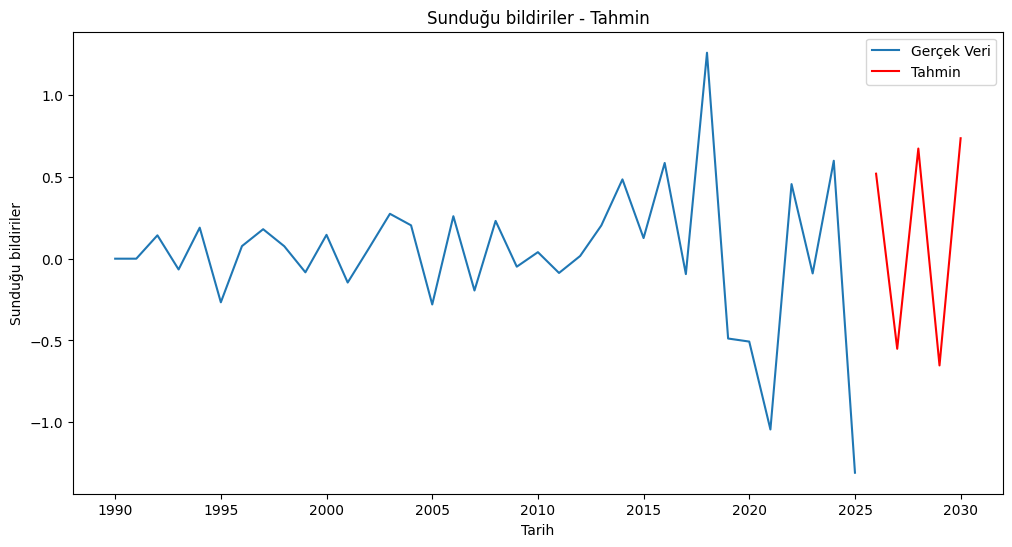

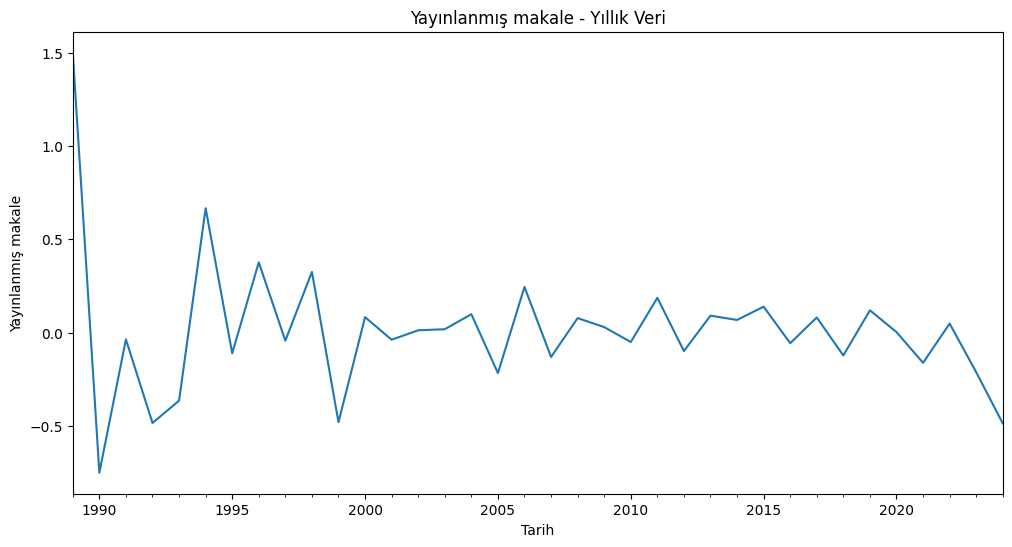

Model Özeti (Yayınlanmış makale):
                               SARIMAX Results                                
Dep. Variable:     Yayınlanmış makale   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  -7.015
Date:                Mon, 12 Aug 2024   AIC                             26.030
Time:                        19:45:38   BIC                             35.531
Sample:                    12-31-1989   HQIC                            29.346
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0118      0.018      0.654      0.513      -0.024       0.047
ar.L1         -0.2294      0.524     -0.438      0.662      -1.257       0.798
ar.L2          0.3

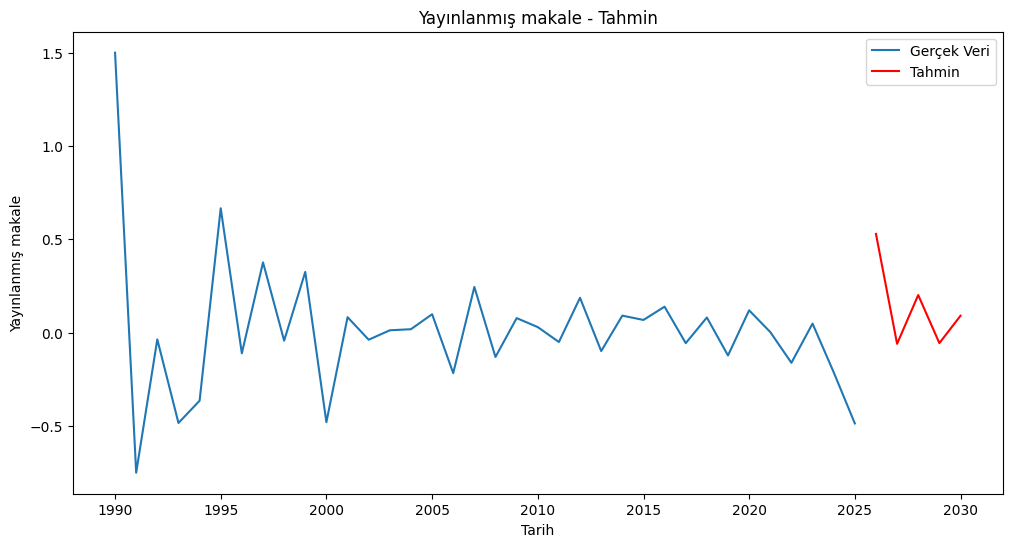

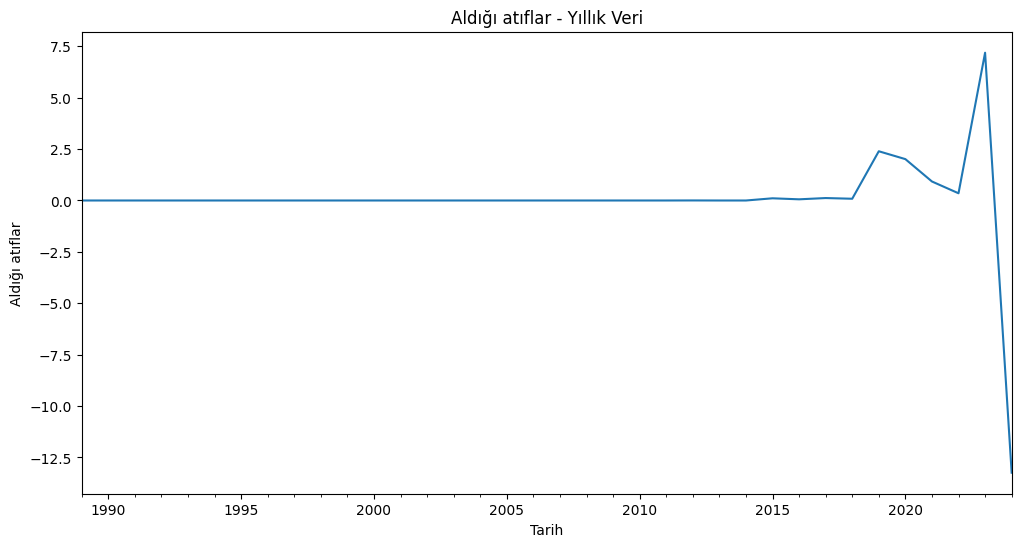

Model Özeti (Aldığı atıflar):
                               SARIMAX Results                                
Dep. Variable:         Aldığı atıflar   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -65.322
Date:                Mon, 12 Aug 2024   AIC                            142.644
Time:                        19:45:39   BIC                            152.146
Sample:                    12-31-1989   HQIC                           145.961
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2052      0.632      0.325      0.745      -1.033       1.443
ar.L1         -0.9491      0.376     -2.522      0.012      -1.687      -0.211
ar.L2         -0.0909 

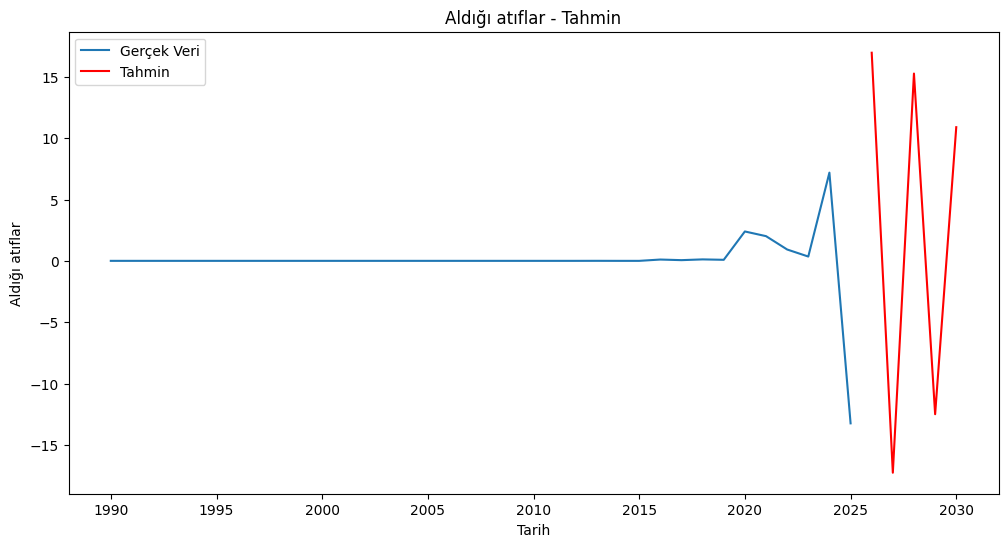

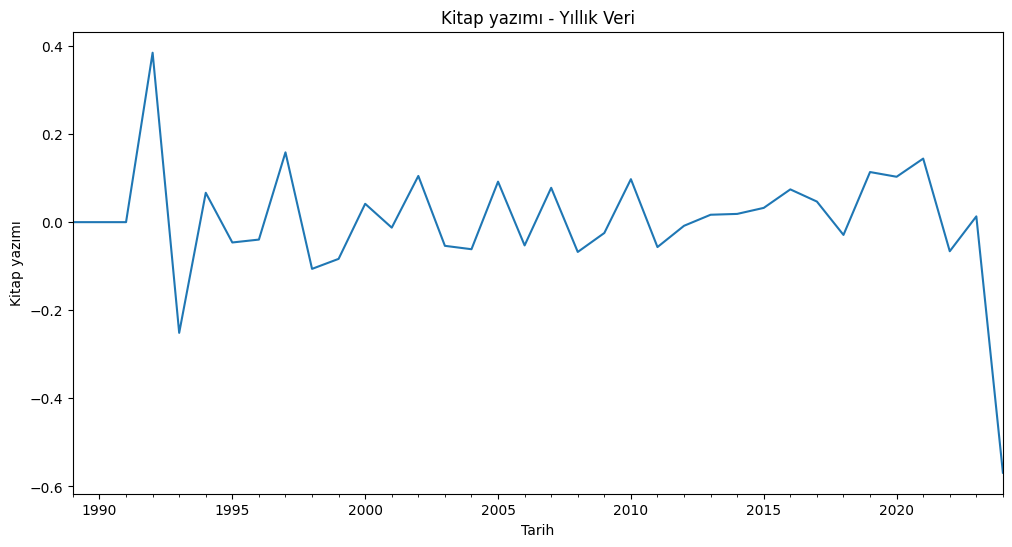

Model Özeti (Kitap yazımı):
                               SARIMAX Results                                
Dep. Variable:           Kitap yazımı   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  23.639
Date:                Mon, 12 Aug 2024   AIC                            -35.278
Time:                        19:45:40   BIC                            -25.777
Sample:                    12-31-1989   HQIC                           -31.962
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.005      1.715      0.086      -0.001       0.020
ar.L1         -0.4173      1.114     -0.374      0.708      -2.601       1.767
ar.L2          0.4315   

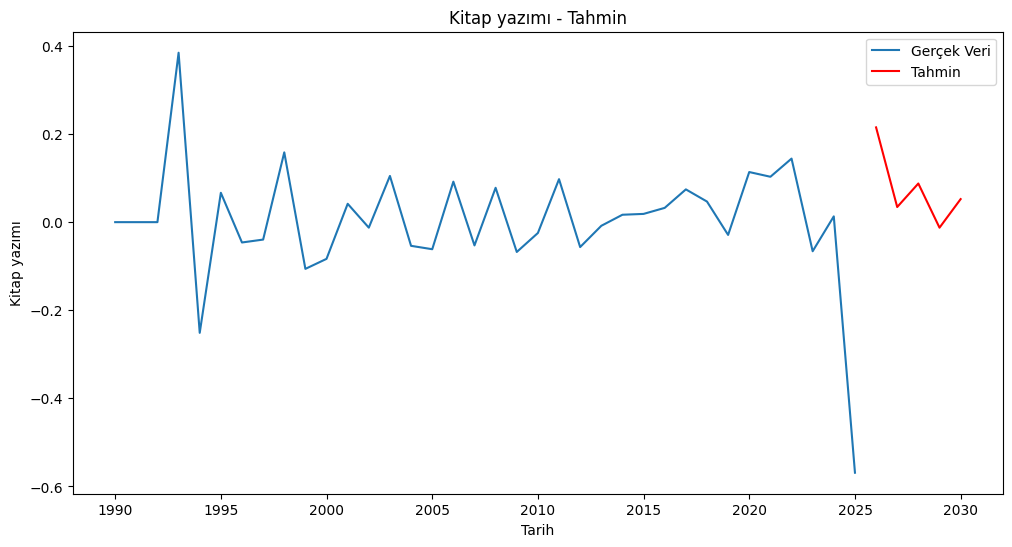

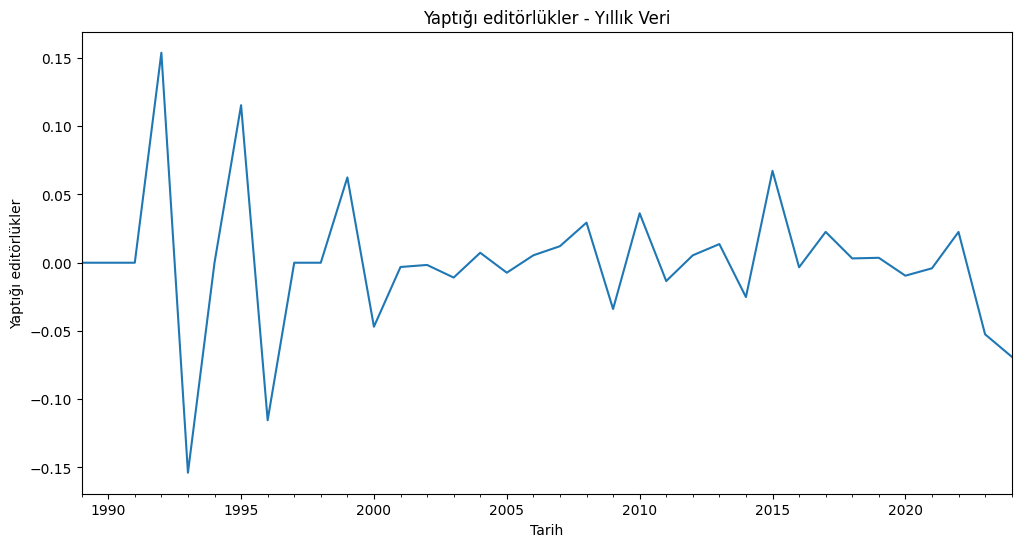

Model Özeti (Yaptığı editörlükler):
                                SARIMAX Results                                 
Dep. Variable:     Yaptığı editörlükler   No. Observations:                   36
Model:                   ARIMA(2, 0, 2)   Log Likelihood                  65.521
Date:                  Mon, 12 Aug 2024   AIC                           -119.042
Time:                          19:45:40   BIC                           -109.541
Sample:                      12-31-1989   HQIC                          -115.726
                           - 12-31-2024                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.005      0.349      0.727      -0.009       0.012
ar.L1         -0.1784      0.313     -0.570      0.569      -0.792       0.435


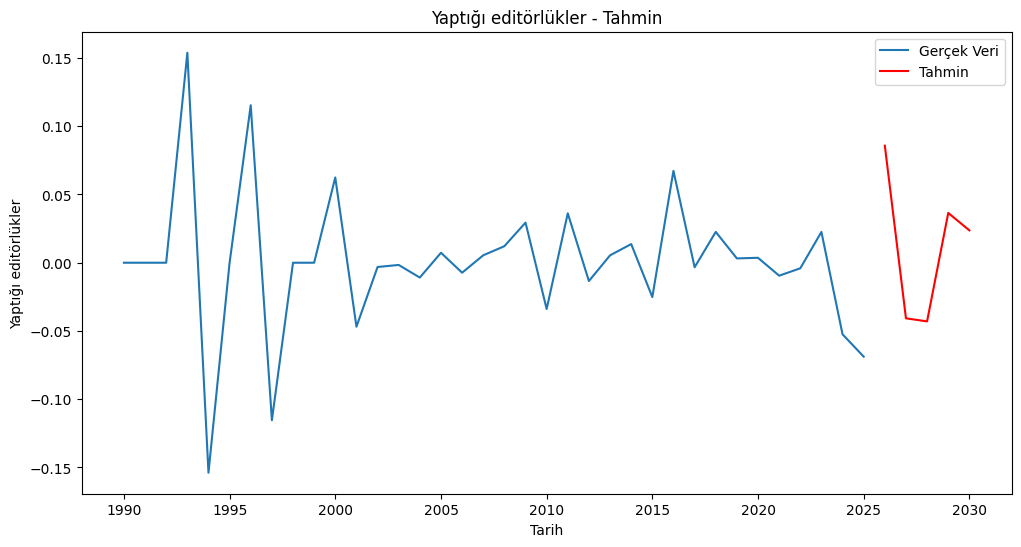

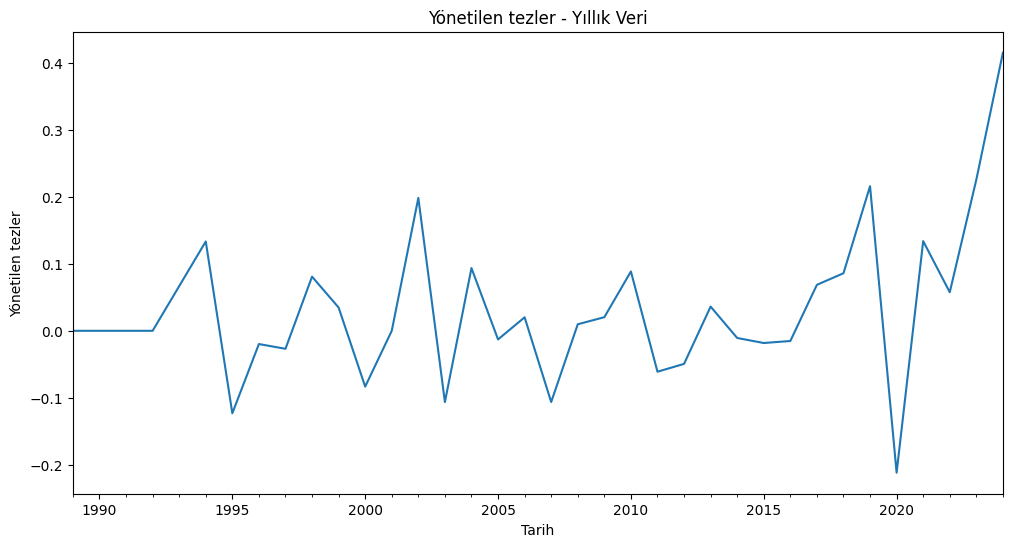

Model Özeti (Yönetilen tezler):
                               SARIMAX Results                                
Dep. Variable:       Yönetilen tezler   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  29.717
Date:                Mon, 12 Aug 2024   AIC                            -47.433
Time:                        19:45:41   BIC                            -37.932
Sample:                    12-31-1989   HQIC                           -44.117
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0370      0.020      1.817      0.069      -0.003       0.077
ar.L1         -1.1818      0.281     -4.209      0.000      -1.732      -0.632
ar.L2         -0.875

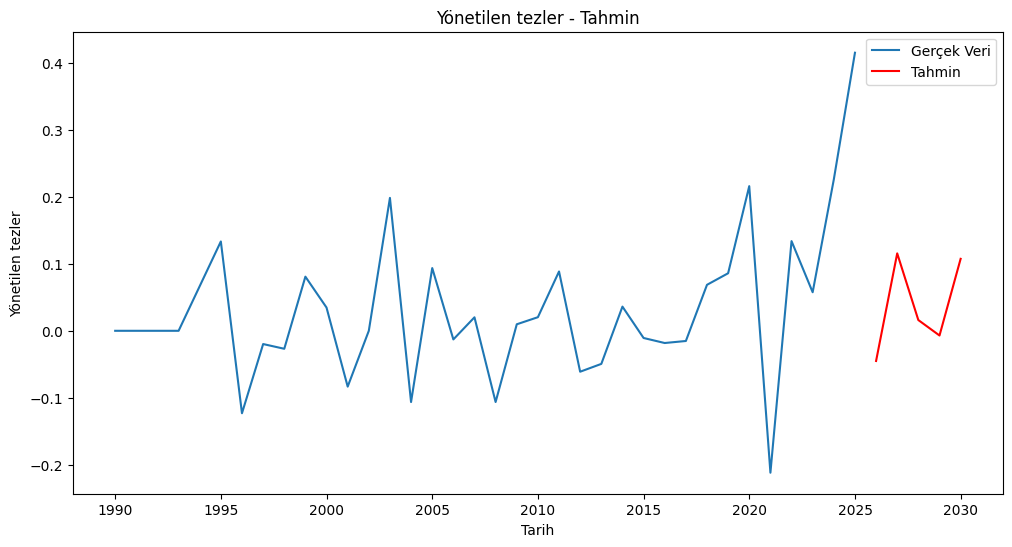

In [105]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Uyarıları bastırma
warnings.filterwarnings('ignore')

# Model uygulayacak sütunlar
columns_to_model = df_diff.columns

for column in columns_to_model:
    plt.figure(figsize=(12, 6))
    
    # Zaman serisini görselleştirme
    df_diff[column].plot(title=f'{column} - Yıllık Veri')
    plt.xlabel('Tarih')
    plt.ylabel(column)
    plt.show()
    
    # ARIMA modelini oluşturma ve eğitme
    model = ARIMA(df_diff[column], order=(2, 0, 2))  # (p, d, q) parametrelerini ayarlayın
    model_fit = model.fit()
    
    # Model özetini görüntüleme
    print(f'Model Özeti ({column}):')
    print(model_fit.summary())
    
    # Tahmin yapma
    forecast = model_fit.forecast(steps=5)  # 5 adım ileri tahmin
    print(f'Tahminler ({column}):')
    print(forecast)
    
    # Tahminlerin görselleştirilmesi
    plt.figure(figsize=(12, 6))
    plt.plot(df_diff.index, df_diff[column], label='Gerçek Veri')
    plt.plot(pd.date_range(start=df_diff.index[-1], periods=6, freq='Y')[1:], forecast, label='Tahmin', color='red')
    plt.title(f'{column} - Tahmin')
    plt.xlabel('Tarih')
    plt.ylabel(column)
    plt.legend()
    plt.show()


Genel olarak, "Ödüller" ve "Yaptığı Editörlükler" modelleri en iyi sonuçları verirken, diğer modellerde bazı anlamlı parametreler eksik veya model uyumu düşük. Özellikle "Sunduğu Bildiriler", "Aldığı Atıflar" ve "Kitap Yazımı" modellerinde uyum sorunları gözüküyor.

In [106]:
train = df_diff['Ödüller']

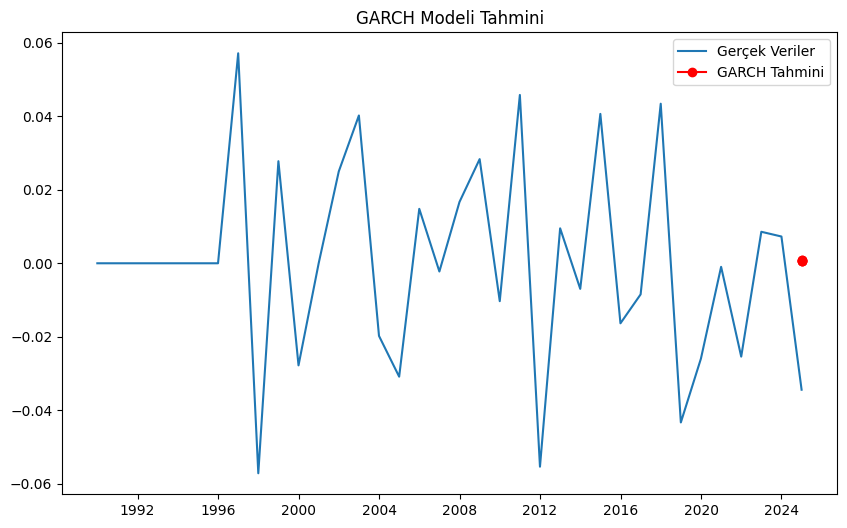

GARCH Tahmini: [0.00085971 0.00076748 0.00074669 0.000742   0.00074094]


In [108]:
# GARCH Modelini Fit Et
def fit_garch_model(train):
    model = arch_model(train, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp="off")
    return model_fit

# 5 Adım İleri Tahmin
def forecast(model_fit, steps=5):
    forecast = model_fit.forecast(start=len(train)-1, horizon=steps)
    return forecast.variance.values[-1, :]

# Modeli Fit Et ve Tahmin Yap
garch_model = fit_garch_model(train)
garch_forecast = forecast(garch_model, steps=5)

# Gerçek ve Tahmin Edilen Değerleri Görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Gerçek Veriler')

# Tahmin edilen varyansların tarihlerle uyumlu olup olmadığını kontrol edin
forecast_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(1), periods=5, freq='D')  # veya uygun frekansta
plt.plot(forecast_dates, garch_forecast, label='GARCH Tahmini', color='red', marker='o')

plt.legend()
plt.title('GARCH Modeli Tahmini')
plt.show()

print(f'GARCH Tahmini: {garch_forecast}')


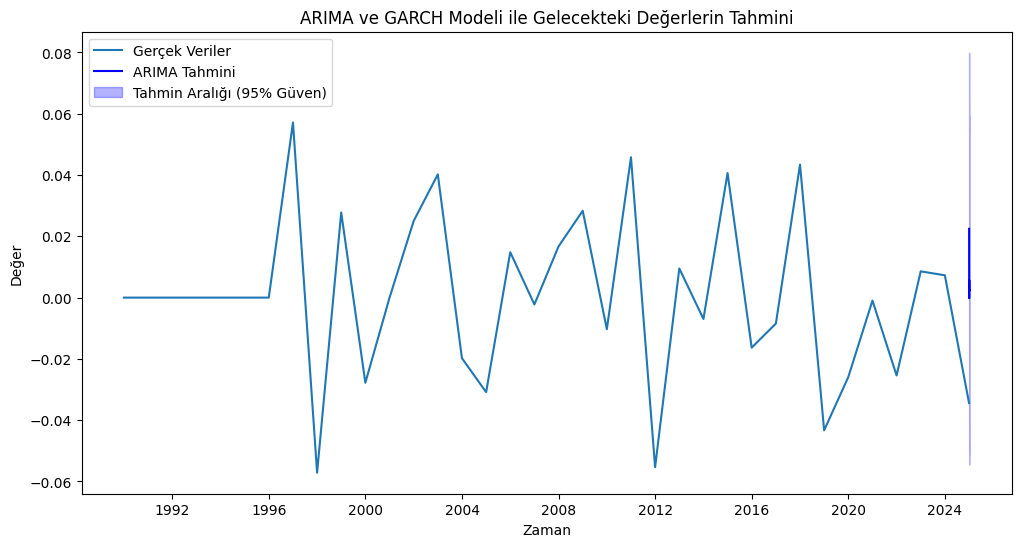

ARIMA Tahmini: 2025-12-31    0.022448
2026-12-31   -0.000191
2027-12-31    0.005664
2028-12-31    0.002236
2029-12-31    0.002467
Freq: A-DEC, Name: predicted_mean, dtype: float64
Volatilite Tahmini: [0.02932079 0.02770351 0.02732556 0.0272396  0.02722018]


In [111]:
# ARIMA Modelini Fit Et
def fit_arima_model(train, order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    return model_fit

# GARCH Modelini Fit Et
def fit_garch_model(train):
    model = arch_model(train, vol='Garch', p=1, q=1)  
    model_fit = model.fit(disp="off")
    return model_fit

# ARIMA ve GARCH ile Tahmin Yap
def combined_forecast(arima_model, garch_model, train, steps=5):
    # ARIMA ile gelecekteki değerleri tahmin et
    arima_forecast = arima_model.forecast(steps=steps)
    
    # GARCH ile gelecekteki volatiliteyi tahmin et
    garch_forecast = garch_model.forecast(start=len(train)-1, horizon=steps)
    volatility_forecast = garch_forecast.variance.values[-1, :]
    
    # Gelecekteki değerleri ve volatiliteyi birleştirme
    forecast_values = arima_forecast
    forecast_volatility = np.sqrt(volatility_forecast)
    
    return forecast_values, forecast_volatility

# Model Parametreleri
arima_order = (2, 0, 2)  # ARIMA(p, d, q) parametreleri


# Modeli Fit Et ve Tahmin Yap
arima_model = fit_arima_model(train, arima_order)
garch_model = fit_garch_model(train)
forecast_values, forecast_volatility = combined_forecast(arima_model, garch_model, train, steps=5)

# Gelecekteki Tarihleri Oluştur
forecast_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(1), periods=5, freq='D')  # Günlük frekansa göre tarihleri ayarlayın

# Gelecekteki Değerleri ve Volatiliteyi Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Gerçek Veriler')
plt.plot(forecast_dates, forecast_values, label='ARIMA Tahmini', color='blue')
plt.fill_between(forecast_dates,
                 forecast_values - 1.96 * forecast_volatility,
                 forecast_values + 1.96 * forecast_volatility,
                 color='blue', alpha=0.3, label='Tahmin Aralığı (95% Güven)')
plt.legend(loc='upper left')  # Legend'i sol üst köşeye taşır
plt.title('ARIMA ve GARCH Modeli ile Gelecekteki Değerlerin Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.show()

print(f'ARIMA Tahmini: {forecast_values}')
print(f'Volatilite Tahmini: {forecast_volatility}')


In [ ]:
last_value = annual_means_clean['Ödüller'].iloc[-1]
# ARIMA tahminlerini içeren bir Seri oluşturun
arima_predictions = pd.Series(forecast_values, name='predicted_mean')

# İlk tahmini, son gerçek değere ekleyerek orijinal seviyeyi hesaplayın
original_values = [last_value + arima_predictions.iloc[0]]

# Diğer tahminler için önceki değeri kullanarak orijinal seviyeleri hesaplayın
for i in range(1, len(arima_predictions)):
    original_values.append(original_values[-1] + arima_predictions.iloc[i])

# Sonuçları bir Seri olarak oluşturun
original_values_series = pd.Series(original_values, index=arima_predictions.index, name='original_mean')


In [ ]:
print(original_values_series)

2025-12-31    0.022448
2026-12-31    0.022256
2027-12-31    0.027921
2028-12-31    0.030156
2029-12-31    0.032623
Freq: A-DEC, Name: original_mean, dtype: float64


In [ ]:
original_values_series.index = pd.to_datetime(original_values_series.index)

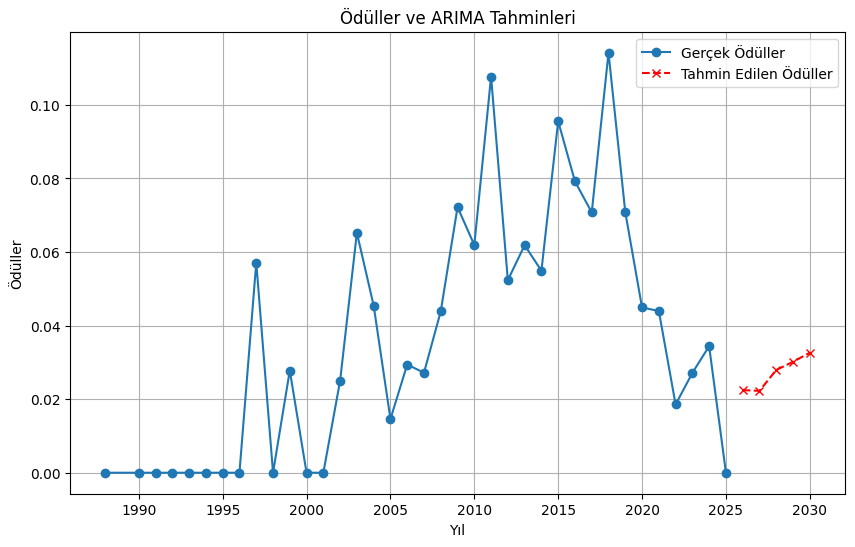

In [ ]:
# Görselleştirme
plt.figure(figsize=(10, 6))

# Gerçek değerler
plt.plot(annual_means_clean.index, annual_means_clean['Ödüller'], marker='o', label='Gerçek Ödüller')

# Tahmin edilen değerler
plt.plot(original_values_series.index, original_values_series, marker='x', linestyle='--', color='red', label='Tahmin Edilen Ödüller')

plt.xlabel('Yıl')
plt.ylabel('Ödüller')
plt.title('Ödüller ve ARIMA Tahminleri')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
train = df_diff['Yaptığı editörlükler']

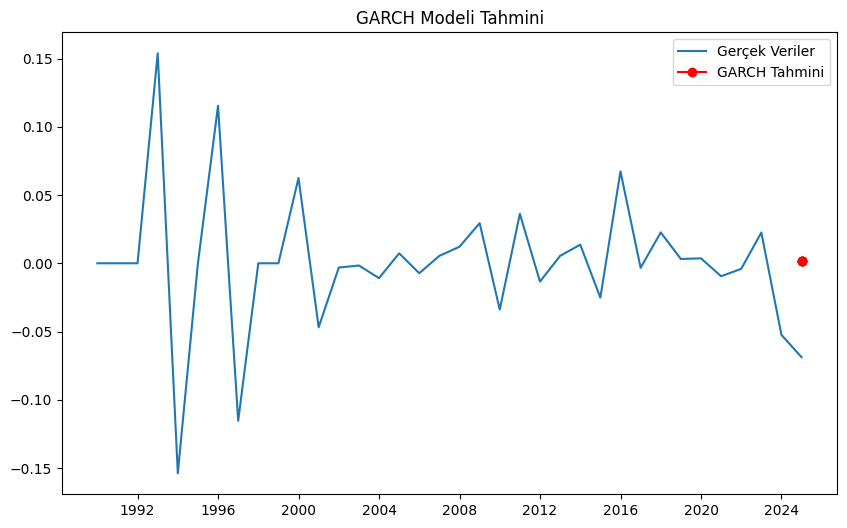

GARCH Tahmini: [0.00182506 0.00177065 0.00172458 0.00168557 0.00165255]


In [123]:
# GARCH Modelini Fit Et
def fit_garch_model(train):
    model = arch_model(train, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp="off")
    return model_fit

# 5 Adım İleri Tahmin
def forecast(model_fit, steps=5):
    forecast = model_fit.forecast(start=len(train)-1, horizon=steps)
    return forecast.variance.values[-1, :]

# Modeli Fit Et ve Tahmin Yap
garch_model = fit_garch_model(train)
garch_forecast = forecast(garch_model, steps=5)

# Gerçek ve Tahmin Edilen Değerleri Görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Gerçek Veriler')

# Tahmin edilen varyansların tarihlerle uyumlu olup olmadığını kontrol edin
forecast_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(1), periods=5, freq='D')  # veya uygun frekansta
plt.plot(forecast_dates, garch_forecast, label='GARCH Tahmini', color='red', marker='o')

plt.legend()
plt.title('GARCH Modeli Tahmini')
plt.show()

print(f'GARCH Tahmini: {garch_forecast}')


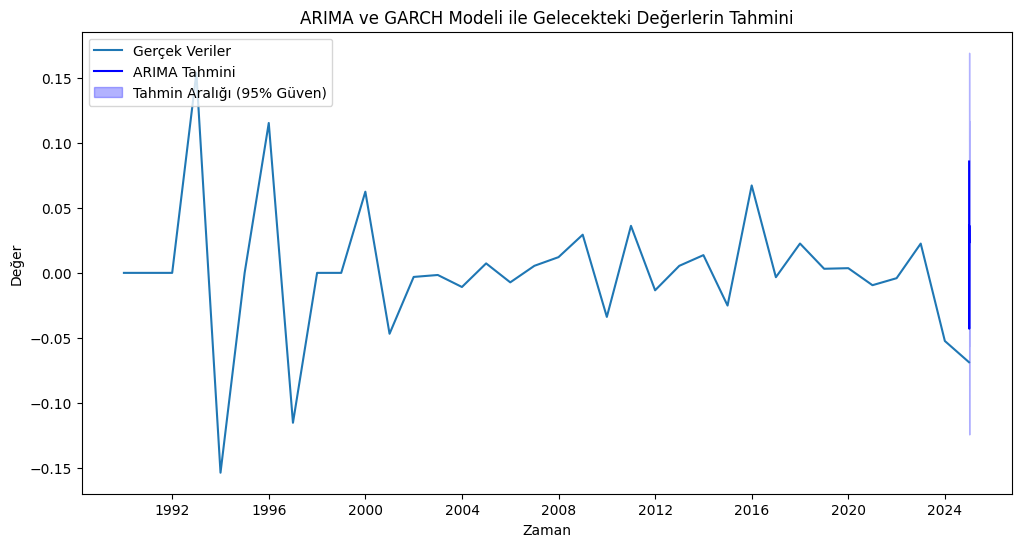

ARIMA Tahmini: 2025-12-31    0.085739
2026-12-31   -0.040732
2027-12-31   -0.042981
2028-12-31    0.036459
2029-12-31    0.023693
Freq: A-DEC, Name: predicted_mean, dtype: float64
Volatilite Tahmini: [0.0427207  0.04207903 0.04152801 0.0410557  0.04065153]


In [124]:
# ARIMA Modelini Fit Et
def fit_arima_model(train, order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    return model_fit

# GARCH Modelini Fit Et
def fit_garch_model(train):
    model = arch_model(train, vol='Garch', p=1, q=1)  
    model_fit = model.fit(disp="off")
    return model_fit

# ARIMA ve GARCH ile Tahmin Yap
def combined_forecast(arima_model, garch_model, train, steps=5):
    # ARIMA ile gelecekteki değerleri tahmin et
    arima_forecast = arima_model.forecast(steps=steps)
    
    # GARCH ile gelecekteki volatiliteyi tahmin et
    garch_forecast = garch_model.forecast(start=len(train)-1, horizon=steps)
    volatility_forecast = garch_forecast.variance.values[-1, :]
    
    # Gelecekteki değerleri ve volatiliteyi birleştirme
    forecast_values = arima_forecast
    forecast_volatility = np.sqrt(volatility_forecast)
    
    return forecast_values, forecast_volatility

# Model Parametreleri
arima_order = (2, 0, 2)  # ARIMA(p, d, q) parametreleri


# Modeli Fit Et ve Tahmin Yap
arima_model = fit_arima_model(train, arima_order)
garch_model = fit_garch_model(train)
forecast_values, forecast_volatility = combined_forecast(arima_model, garch_model, train, steps=5)

# Gelecekteki Tarihleri Oluştur
forecast_dates = pd.date_range(start=train.index[-1] + pd.DateOffset(1), periods=5, freq='D')  # Günlük frekansa göre tarihleri ayarlayın

# Gelecekteki Değerleri ve Volatiliteyi Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Gerçek Veriler')
plt.plot(forecast_dates, forecast_values, label='ARIMA Tahmini', color='blue')
plt.fill_between(forecast_dates,
                 forecast_values - 1.96 * forecast_volatility,
                 forecast_values + 1.96 * forecast_volatility,
                 color='blue', alpha=0.3, label='Tahmin Aralığı (95% Güven)')
plt.legend(loc='upper left')  # Legend'i sol üst köşeye taşır
plt.title('ARIMA ve GARCH Modeli ile Gelecekteki Değerlerin Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.show()

print(f'ARIMA Tahmini: {forecast_values}')
print(f'Volatilite Tahmini: {forecast_volatility}')

In [125]:
last_value = annual_means_clean['Yaptığı editörlükler'].iloc[-1]
# ARIMA tahminlerini içeren bir Seri oluşturun
arima_predictions = pd.Series(forecast_values, name='predicted_mean')

# İlk tahmini, son gerçek değere ekleyerek orijinal seviyeyi hesaplayın
original_values = [last_value + arima_predictions.iloc[0]]

# Diğer tahminler için önceki değeri kullanarak orijinal seviyeleri hesaplayın
for i in range(1, len(arima_predictions)):
    original_values.append(original_values[-1] + arima_predictions.iloc[i])

# Sonuçları bir Seri olarak oluşturun
original_values_series = pd.Series(original_values, index=arima_predictions.index, name='original_mean')


In [126]:
print(original_values_series)

2025-12-31    0.096492
2026-12-31    0.055760
2027-12-31    0.012779
2028-12-31    0.049238
2029-12-31    0.072931
Freq: A-DEC, Name: original_mean, dtype: float64


In [127]:
original_values_series.index = pd.to_datetime(original_values_series.index)

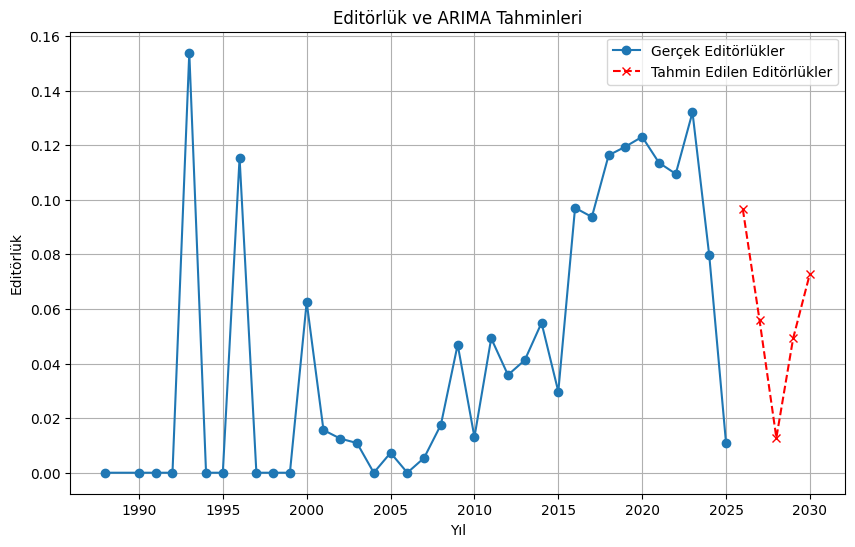

In [128]:
# Görselleştirme
plt.figure(figsize=(10, 6))

# Gerçek değerler
plt.plot(annual_means_clean.index, annual_means_clean['Yaptığı editörlükler'], marker='o', label='Gerçek Editörlükler')

# Tahmin edilen değerler
plt.plot(original_values_series.index, original_values_series, marker='x', linestyle='--', color='red', label='Tahmin Edilen Editörlükler')

plt.xlabel('Yıl')
plt.ylabel('Editörlük')
plt.title('Editörlük ve ARIMA Tahminleri')
plt.legend()
plt.grid(True)
plt.show()